In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as k

import DAN_code.functions as func
import DAN_code.data_processing as data_proc
import DAN_code.initializers as init
from DAN_code import models

from tensorflow.keras.datasets import mnist, fashion_mnist

import matplotlib.pyplot as plt
import DAN_code.result_plotting as res_plot
import DAN_code.result_testing as res_test
import time

from DAN_code.serialize_custom_objects import collect_custom_objects
import os

eps = np.finfo("float32").eps

# %load_ext tensorboard

2025-06-23 10:36:43.105856: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 10:36:43.167782: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-23 10:36:45.970744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
print(os.path.dirname(tf.__file__))
print(tf.__version__)

/home/rtheriault/.local/lib/python3.8/site-packages/tensorflow
2.13.1


In [6]:
custom_objects = collect_custom_objects()

seed = 2
np_rng = np.random.default_rng(seed)

dataset = mnist
softening = 0.1

# Import data and reshape to vectors
x_train, y_train, x_test, y_test = data_proc.prepare_flat_data(dataset, normalize_data = True, softening = softening)

# Loss type
loss = "supervised"

number_features = x_train.shape[1]
input_shape = (number_features,)
number_splits = 14
number_classes = y_train.shape[1]
number_constraint_iterations = 10
batch_size = 1000

number_memorization_epochs = 100
number_annealing_epochs = 50


# number_memorization_epochs = 150
# number_annealing_epochs = 75

# number_memorization_epochs = 175
# number_annealing_epochs = 88


# number_memorization_epochs = 200
# number_annealing_epochs = 100

# number_memorization_epochs = 225
# number_annealing_epochs = 113

# number_memorization_epochs = 250
# number_annealing_epochs = 125

# number_memorization_epochs = 275
# number_annealing_epochs = 138

# number_memorization_epochs = 300
# number_annealing_epochs = 150


number_splitting_epochs = 100
dataset_size = x_train.shape[0]


# Hyperparameter values
beta_init = 8.
beta_final = 40.
slope = 4
beta_range = np.concatenate([np.array([beta_init]), np.full((number_splits + 1,), beta_final)])
patience = 1

learning_rate = 0.1
momentum = 0.99

max_fraction_eigvals = 1.
max_eigval = -0.001

normalize_online = False
save_model = True

y_hard = np.argmax(y_train, axis = 1)
counts_y = np.bincount(y_hard)
counts_y = np.concatenate([counts_y, np.array([0])])
prior_y = (1 - softening) * counts_y / np.sum(counts_y) + softening * 1/(number_classes + 1)


# max_number_memories = 500
# max_number_memories = 750

# max_number_memories = 1000
max_number_memories = 1250
# max_number_memories = 1500
# max_number_memories = 1750
# max_number_memories = 2000


init_number_memories = 100

# init_number_memories = 500
# init_number_memories = 750

# init_number_memories = 1000
# init_number_memories = 1250
# init_number_memories = 1500
# init_number_memories = 1750
# init_number_memories = 2000

x_train = tf.convert_to_tensor(x_train, dtype = "float32")
y_train = tf.convert_to_tensor(y_train, dtype = "float32")

In [2]:
number_repeats = 10

run_times = []
accuracies = []

for _ in range(number_repeats):
    run_time = np.inf
    np_seed, tf_seed = np_rng.integers(0, 2**63, size = 2)
    np_rng = np.random.default_rng(np_seed)
    tf.random.set_seed(tf_seed)
    
    #for _ in range(1):
    for _ in range(number_repeats):
        beta_init = beta_range[0]
        model = models.init_DAN(loss, beta_init, softening, number_features, init_number_memories, max_number_memories,
                                number_classes, number_constraint_iterations, learning_rate, momentum,
                                prior_y, normalize_online = normalize_online)

        start_time = time.perf_counter()
        for split in range(number_splits + 1):
            cur_split = split

            beta_final = beta_range[split + 1]

            model = models.train_DAN(x_train, y_train, model, number_memorization_epochs,
                                     number_annealing_epochs, batch_size, beta_final, slope, patience,
                                     training_phase = "memorization", record = None, verbose = False)
            
            number_memories = model.get_DAN_layer(1).output_size
            max_number_memories = model.get_DAN_layer(1).max_output_size

            if number_memories == max_number_memories:
                break

            elif split == number_splits:
                break

            else:
                model = models.train_DAN(x_train, y_train, model, number_splitting_epochs,
                                         0, batch_size, beta_final, slope, patience,
                                         training_phase = "splitting", record = None, verbose = False)

                max_number_eigvals = int(np.rint(max_fraction_eigvals * number_memories))
                mask = models.calc_split_mask(x_train, y_train, model, max_number_eigvals,
                                              max_eigval, batch_size, adjust = True)

                if not k.any(mask):
                    break

                init.split_memories(model, mask, 0.25)

        end_time = time.perf_counter()

        run_time = np.minimum(run_time, end_time - start_time)
    
    print(run_time)
    run_times.append(run_time)
    
    w_cur = model.get_DAN_layer(1).get_weights()[0]
    g_cur = model.get_DAN_layer(2).get_weights()[0]

    w_plot = w_cur[:, : 25].T
    g_plot = g_cur[: 25].T

    res_plot.plot_images(w_plot)

    y_hard = np.argmax(model.predict(w_plot), axis = 1)
    res_plot.plot_labels(y_hard, g_plot)

    models.compile_memorization_phase(model)

    accuracy = model.evaluate(x_test, y_test)[1]
    accuracies.append(accuracy)

#print(accuracies)
#print(run_times)
#raise NotImplementedError

beta = beta_final
number_splits = cur_split
with open("./Data/Performance/DAN_accuracy_and_run_time_with_beta=%s_and_%s_memories_for_%s_splits.npy"
          % (str(beta), str(number_memories), str(number_splits)), "wb") as f:
    np.save(f, np.array(run_times))
    np.save(f, np.array(accuracies))

NameError: name 'np_rng' is not defined

In [25]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

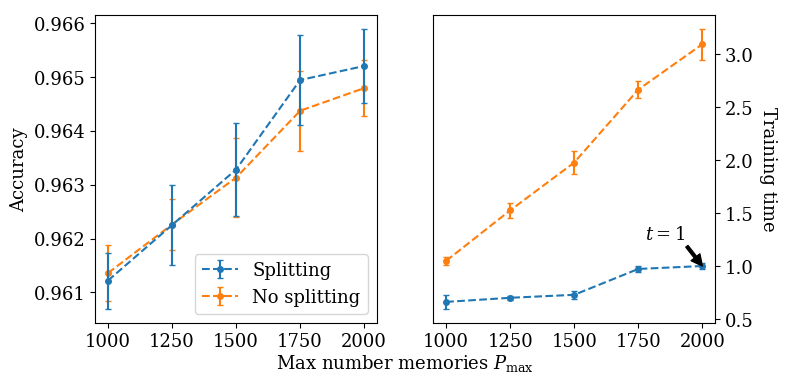

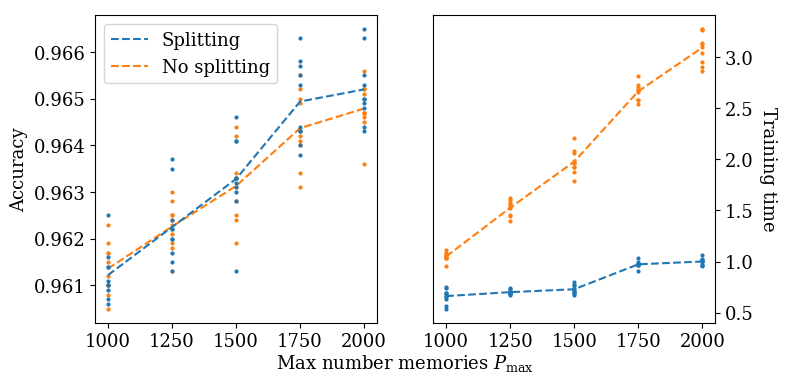

In [27]:
beta = 40.

number_memories_range = [1000, 1250, 1500, 1750, 2000]
number_splits_range = [4, 4, 4, 5, 5]

run_time_with_splits = []
accuracy_with_splits = []
run_time_without_splits = []
accuracy_without_splits = []
for number_memories, number_splits in zip(number_memories_range, number_splits_range):
    with open("./Data/Performance/DAN_accuracy_and_run_time_with_beta=%s_and_%s_memories_for_%s_splits.npy"
              % (str(beta), str(number_memories), str(number_splits)), "rb") as f:
        run_time = np.load(f)
        accuracy = np.load(f)
    
    run_time_with_splits.append(run_time)
    accuracy_with_splits.append(accuracy)
    
    with open("./Data/Performance/DAN_accuracy_and_run_time_with_beta=%s_and_%s_memories_for_%s_splits.npy"
              % (str(beta), str(number_memories), str(0)), "rb") as f:
        run_time = np.load(f)
        accuracy = np.load(f)
    
    run_time_without_splits.append(run_time)
    accuracy_without_splits.append(accuracy)

scaling_factor = np.mean(run_time_with_splits[-1])

run_time_with_splits = np.array(run_time_with_splits / scaling_factor)
accuracy_with_splits = np.array(accuracy_with_splits)

mean_run_time_with_splits = np.mean(run_time_with_splits, axis = 1)
std_run_time_with_splits = np.std(run_time_with_splits, axis = 1)
mean_accuracy_with_splits = np.mean(accuracy_with_splits, axis = 1)

run_time_without_splits = np.array(run_time_without_splits / scaling_factor)
accuracy_without_splits = np.array(accuracy_without_splits)

mean_run_time_without_splits = np.mean(run_time_without_splits, axis = 1)
std_run_time_without_splits = np.std(run_time_without_splits, axis = 1)
mean_accuracy_without_splits = np.mean(accuracy_without_splits, axis = 1)

fontsize = 13

fig, axes = plt.subplots(1, 2, sharex = True, figsize = (8, 4))
fig_axis = fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)

axes[0].errorbar(number_memories_range, mean_accuracy_with_splits, std_accuracy_with_splits,
                 marker = "o", linestyle = "--", capsize = 2, zorder = 2.5, color = "C0",
                 markersize = 4, label = "Splitting")
axes[0].errorbar(number_memories_range, mean_accuracy_without_splits, std_accuracy_without_splits,
                 marker = "o", linestyle = "--", capsize = 2, zorder = 1.5, color = "C1",
                 markersize = 4, label = "No splitting")
axes[0].legend(fontsize = fontsize)
axes[0].set_xticks(number_memories_range)
axes[0].set_ylabel(r"Accuracy", fontsize = fontsize)
axes[0].tick_params(axis = "both", which = "both", labelsize = fontsize)

axes[1].errorbar(number_memories_range, mean_run_time_with_splits, std_run_time_with_splits,
                 marker = "o", linestyle = "--", capsize = 2, zorder = 2.5, color = "C0", markersize = 4)
axes[1].errorbar(number_memories_range, mean_run_time_without_splits, std_run_time_without_splits,
                 marker = "o", linestyle = "--", capsize = 2, zorder = 1.5, color = "C1", markersize = 4)
# axes[1].set_box_aspect(1)
axes[1].set_xticks(number_memories_range)
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
axes[1].set_ylabel(r"Training time", fontsize = fontsize, rotation = -90, labelpad = 17)
axes[1].tick_params(axis = "both", which = "both", labelsize = fontsize)
axes[1].annotate(r"$t = 1$", (2000, 1), (1775, 1.25), fontsize = fontsize,
                 arrowprops = {"width" : 2, "headwidth" : 8, "headlength" : 8,
                               "shrink" : 1, "color" : "black"})

fig_axis.set_xlabel(r"Max number memories $P_{\mathrm{max}}$", fontsize = fontsize)
plt.show()

fig, axes = plt.subplots(1, 2, sharex = True, figsize = (8, 4))
fig_axis = fig.add_subplot(111, frameon = False)
plt.tick_params(labelcolor = "none", which = "both", top = False, bottom = False, left = False, right = False)

axes[0].plot(number_memories_range, mean_accuracy_with_splits,
             marker = "none", linestyle = "--", zorder = 2.5, color = "C0",
             label = "Splitting")
axes[0].plot(number_memories_range, mean_accuracy_without_splits,
             marker = "none", linestyle = "--", zorder = 1.5, color = "C1",
             label = "No splitting")

axes[0].plot(number_memories_range, accuracy_with_splits, marker = "o",
             markersize = 2, linestyle = "none", zorder = 2.5, color = "C0")
axes[0].plot(number_memories_range, accuracy_without_splits,
             markersize = 2, marker = "o", linestyle = "none", zorder = 1.5, color = "C1")

axes[0].legend(fontsize = fontsize)
axes[0].set_xticks(number_memories_range)
axes[0].set_ylabel(r"Accuracy", fontsize = fontsize)
axes[0].tick_params(axis = "both", which = "both", labelsize = fontsize)

axes[1].plot(number_memories_range, mean_run_time_with_splits,
             marker = "none", linestyle = "--", zorder = 2.5, color = "C0")
axes[1].plot(number_memories_range, mean_run_time_without_splits,
             marker = "none", linestyle = "--", zorder = 1.5, color = "C1")

axes[1].plot(number_memories_range, run_time_with_splits,
             marker = "o", markersize = 2, linestyle = "none", zorder = 2.5, color = "C0")
axes[1].plot(number_memories_range, run_time_without_splits,
             marker = "o", markersize = 2, linestyle = "none", zorder = 1.5, color = "C1")
# axes[1].set_box_aspect(1)
axes[1].set_xticks(number_memories_range)
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position("right")
axes[1].set_ylabel(r"Training time", fontsize = fontsize, rotation = -90, labelpad = 17)
axes[1].tick_params(axis = "both", which = "both", labelsize = fontsize)
#axes[1].annotate(r"$t = 1$", (2000, 1), (1775, 1.25), fontsize = fontsize,
#                 arrowprops = {"width" : 2, "headwidth" : 8, "headlength" : 8,
#                               "shrink" : 1, "color" : "black"})

fig_axis.set_xlabel(r"Max number memories $P_{\mathrm{max}}$", fontsize = fontsize)
plt.show()

Epoch 1/200
54/54 [==============================] - 3s 41ms/step - loss: -4.7005 - accuracy: 0.1132 - val_loss: -4.8613 - val_accuracy: 0.1050
Epoch 2/200
54/54 [==============================] - 2s 39ms/step - loss: -5.1284 - accuracy: 0.1132 - val_loss: -5.4473 - val_accuracy: 0.1050
Epoch 3/200
54/54 [==============================] - 2s 39ms/step - loss: -5.8140 - accuracy: 0.1132 - val_loss: -6.2104 - val_accuracy: 0.1050
Epoch 4/200
54/54 [==============================] - 2s 39ms/step - loss: -6.5991 - accuracy: 0.1132 - val_loss: -6.9870 - val_accuracy: 0.1050
Epoch 5/200
54/54 [==============================] - 2s 39ms/step - loss: -7.3055 - accuracy: 0.1132 - val_loss: -7.5983 - val_accuracy: 0.1050
Epoch 6/200
54/54 [==============================] - 2s 39ms/step - loss: -7.8138 - accuracy: 0.1132 - val_loss: -8.0061 - val_accuracy: 0.1050
Epoch 7/200
54/54 [==============================] - 2s 39ms/step - loss: -8.1447 - accuracy: 0.1132 - val_loss: -8.2681 - val_accuracy:

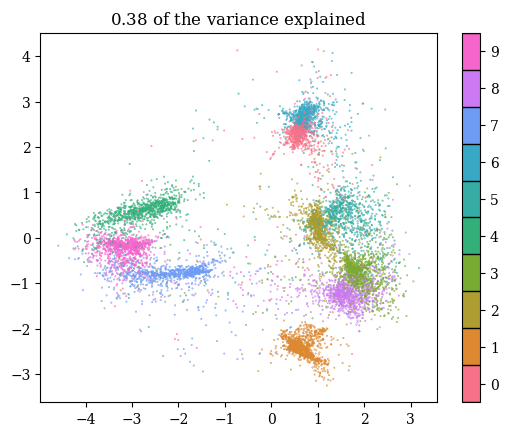

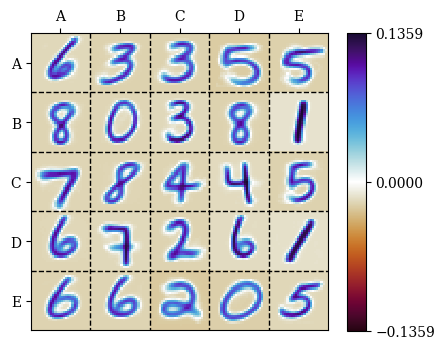

1/1 [==============================] - 0s 18ms/step


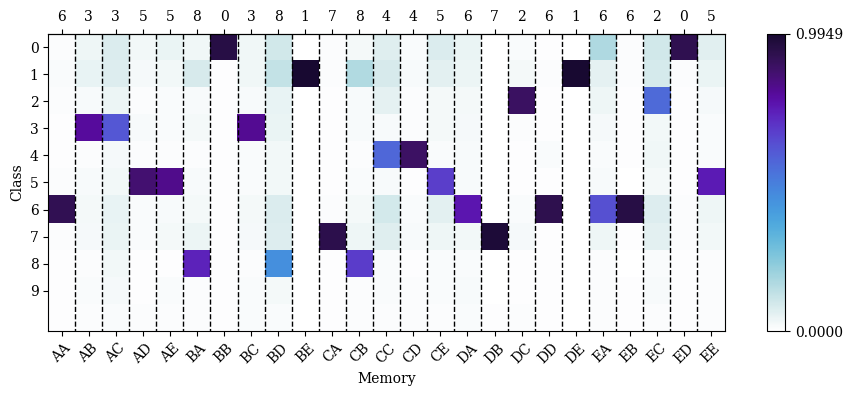

32/32 [==============================] - 0s 2ms/step


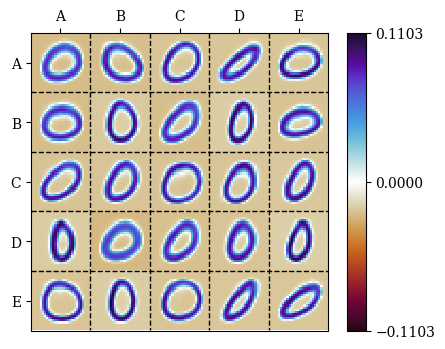

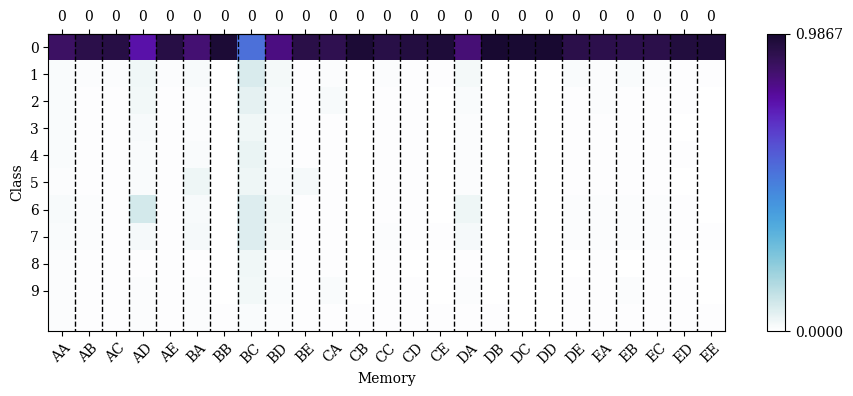

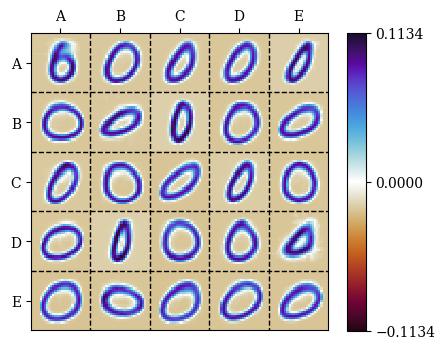

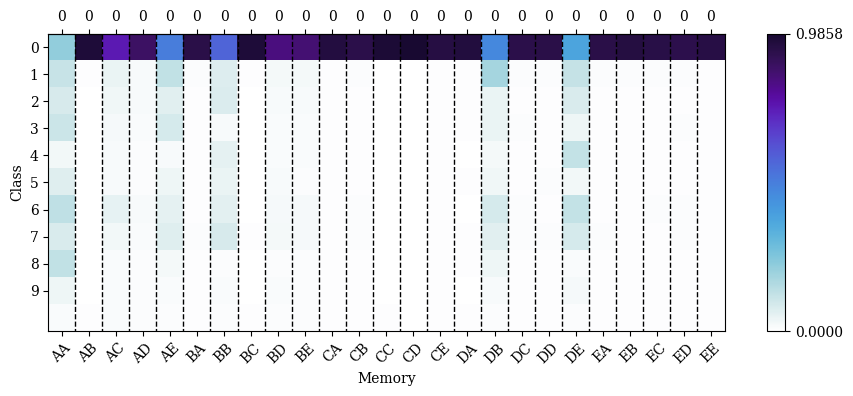

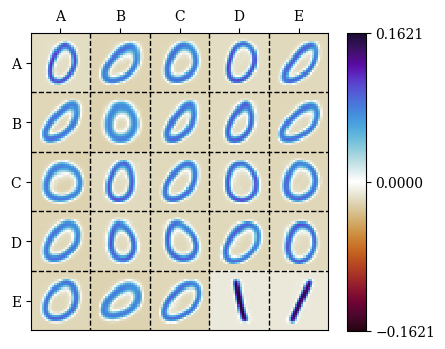

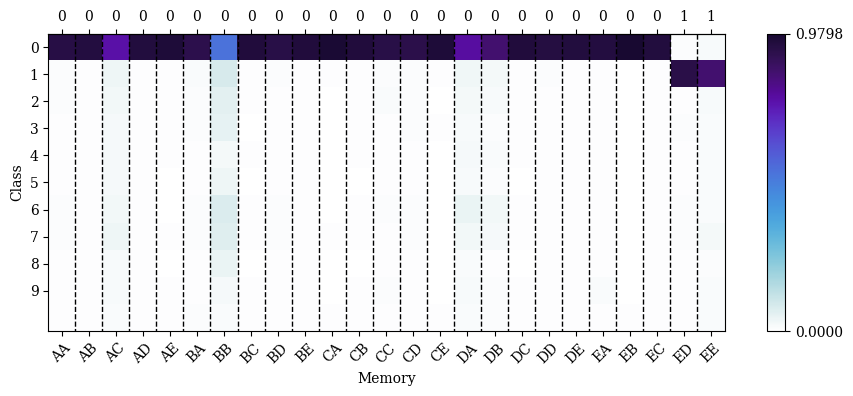

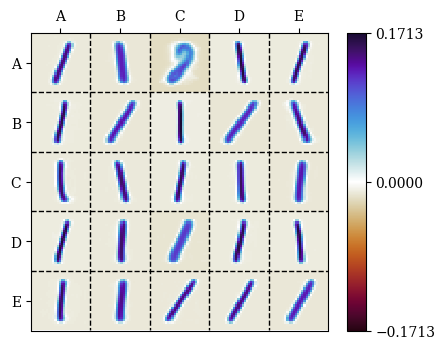

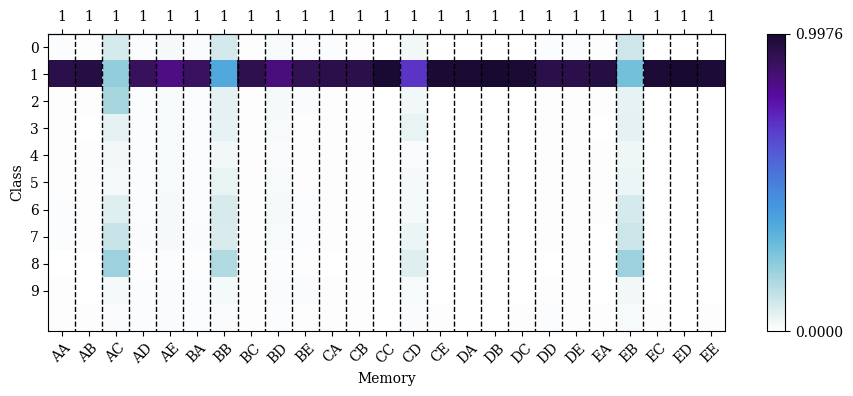

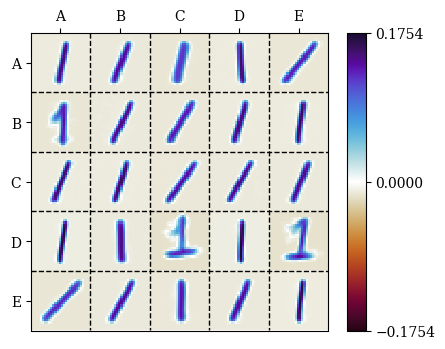

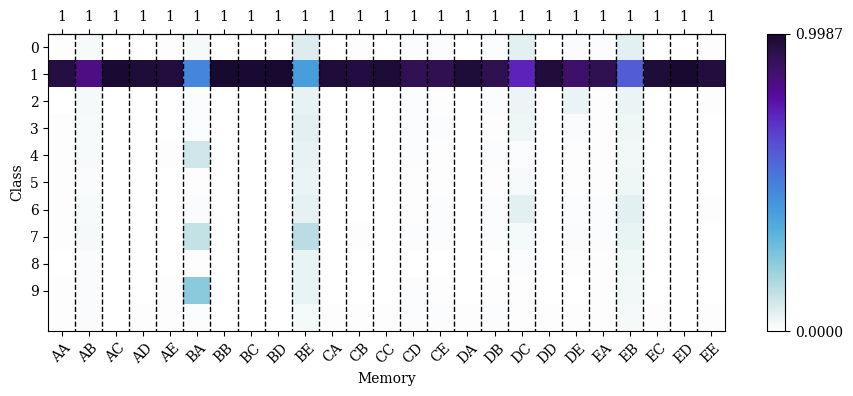

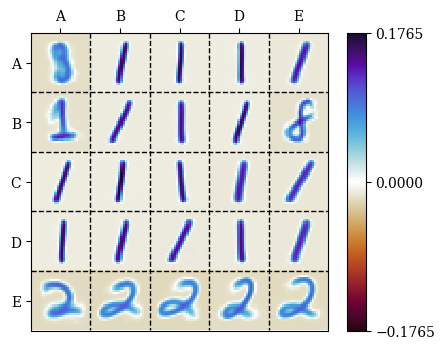

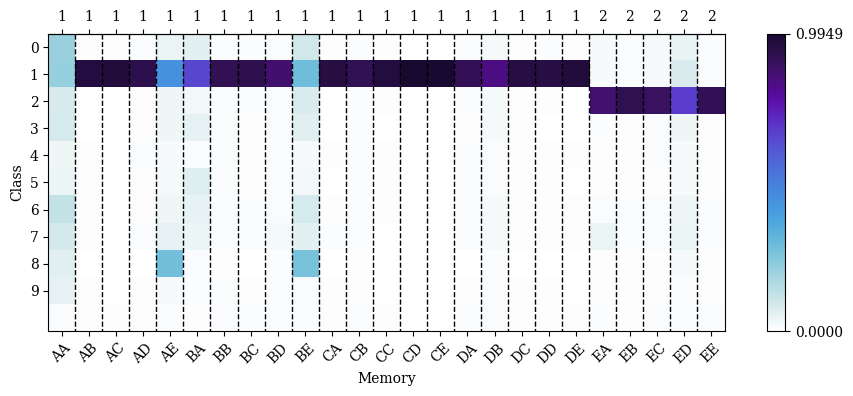

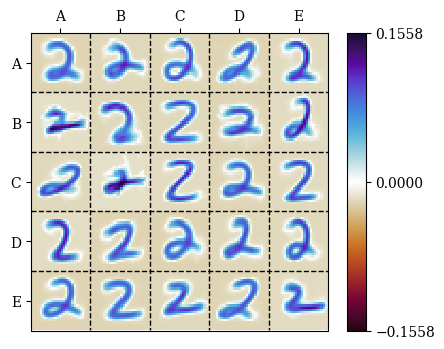

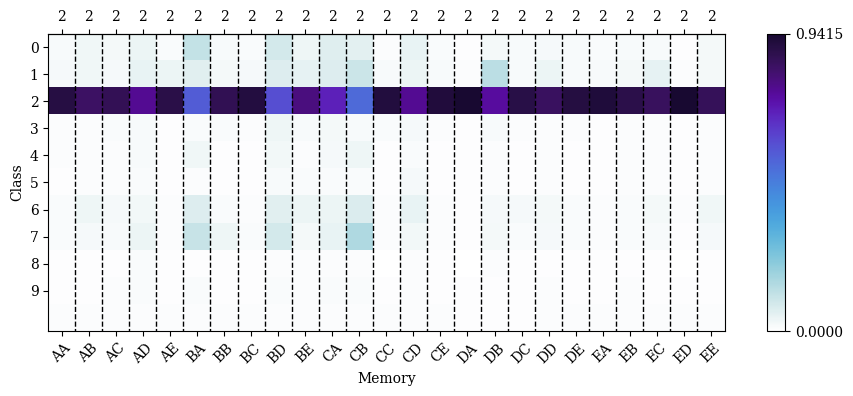

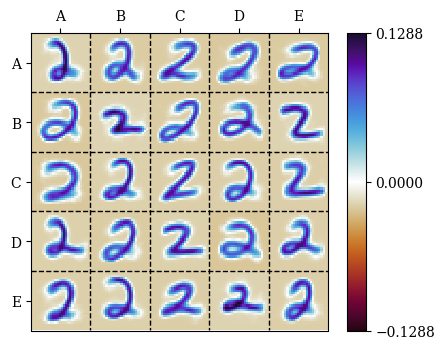

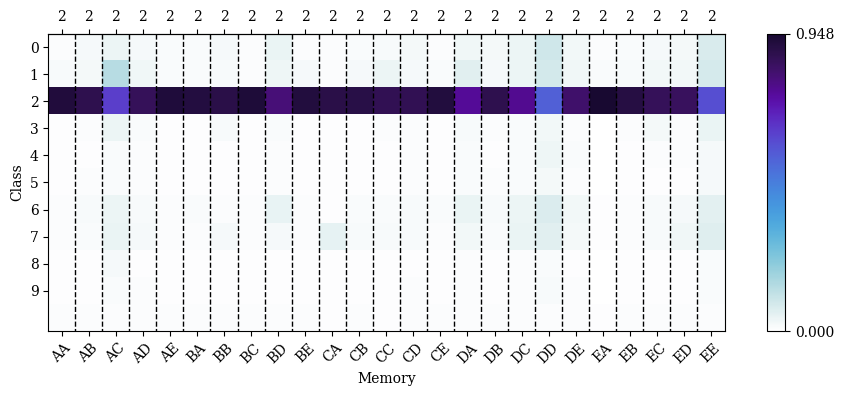

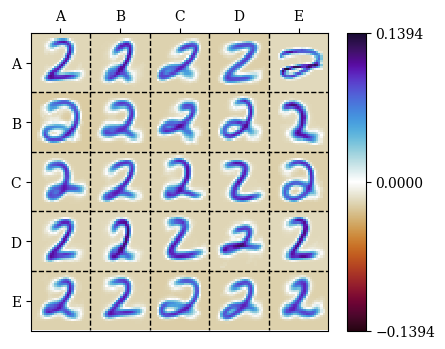

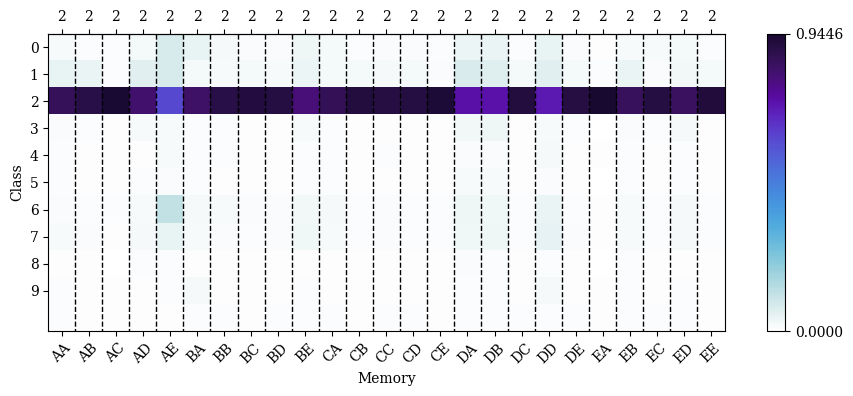

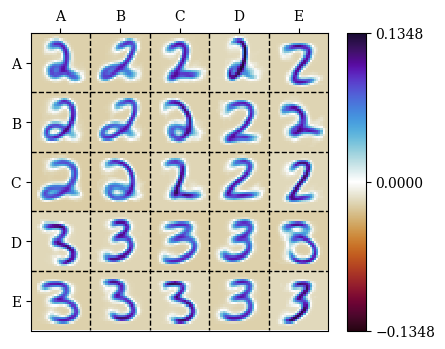

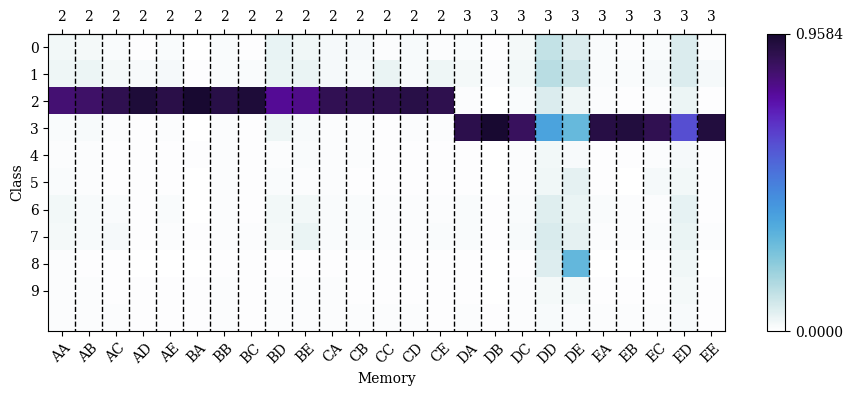

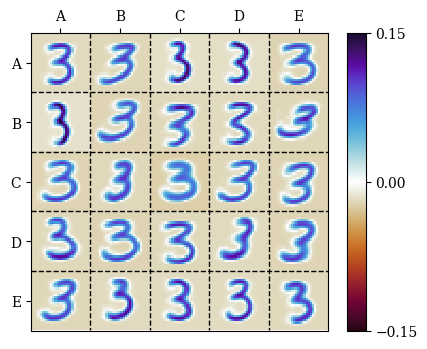

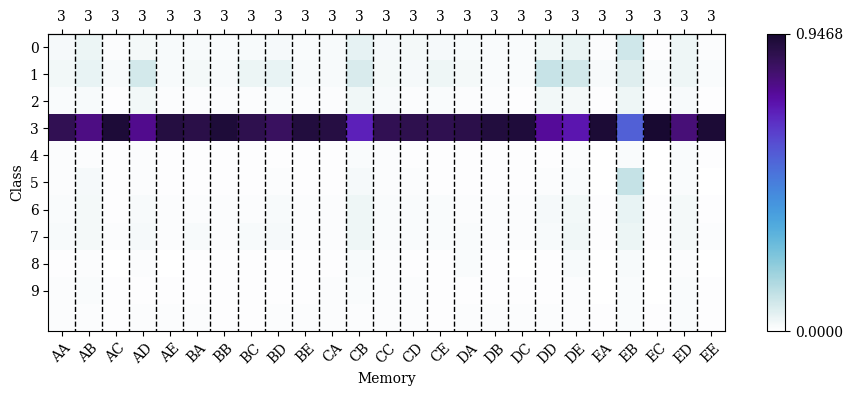

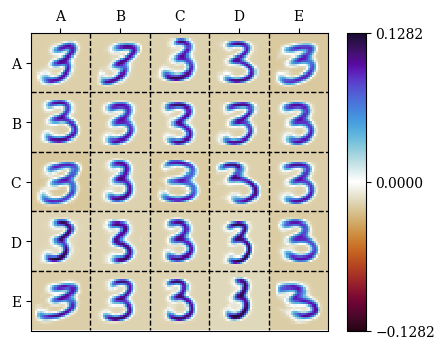

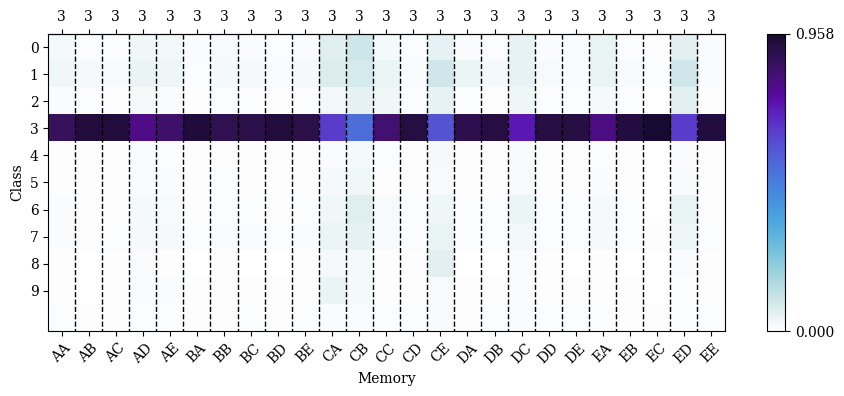

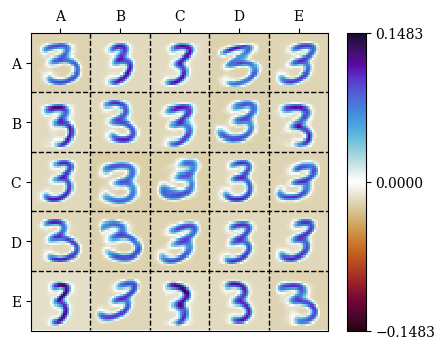

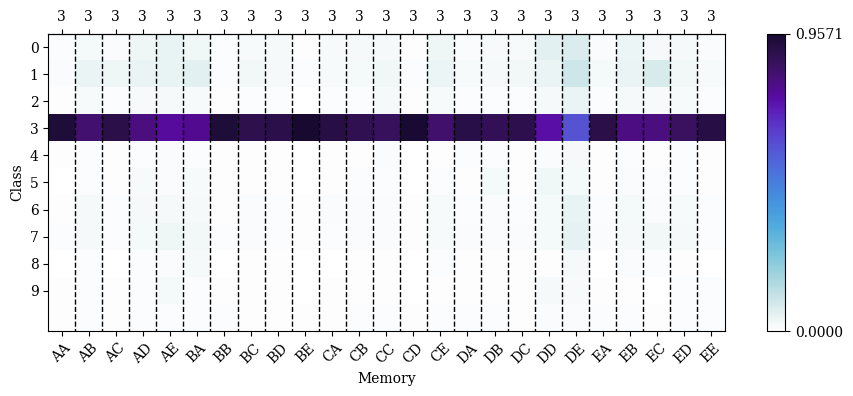

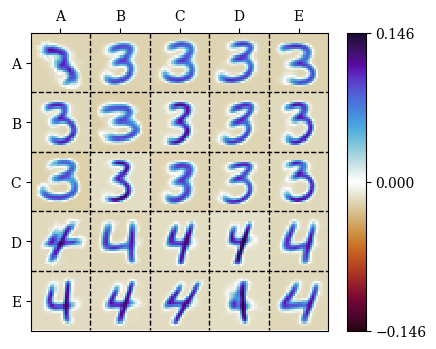

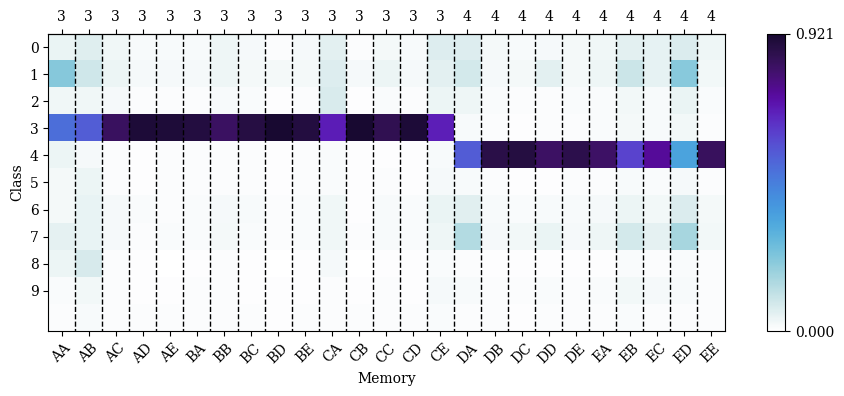

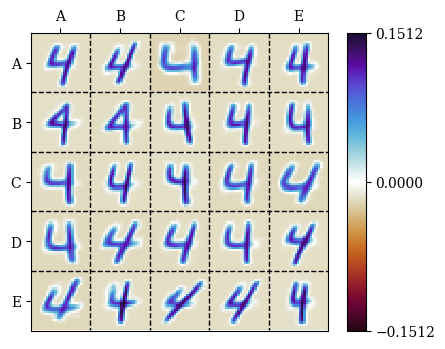

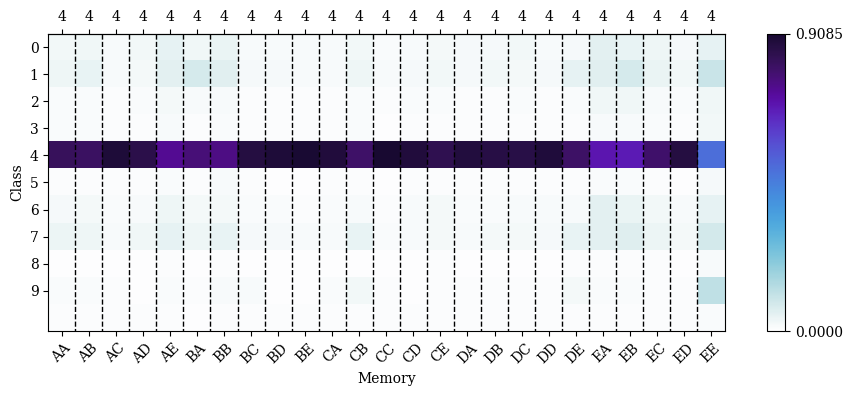

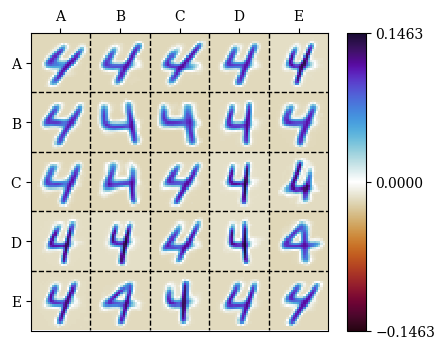

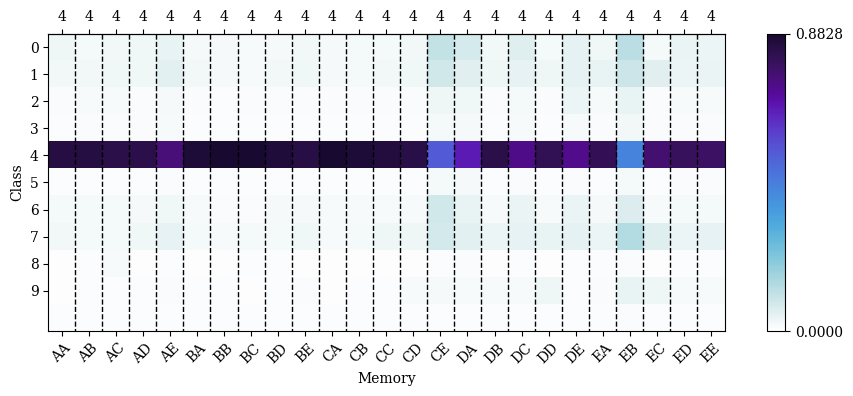

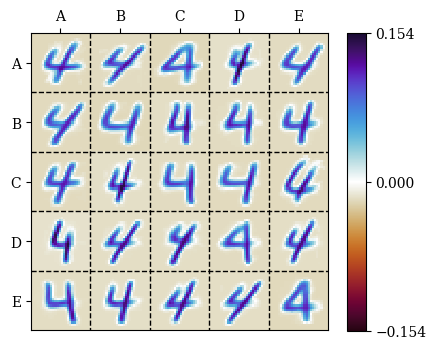

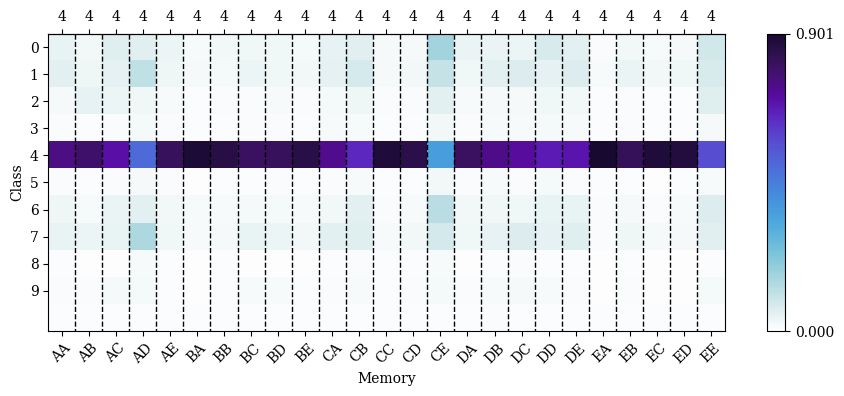

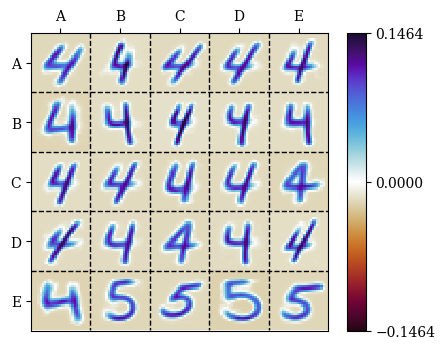

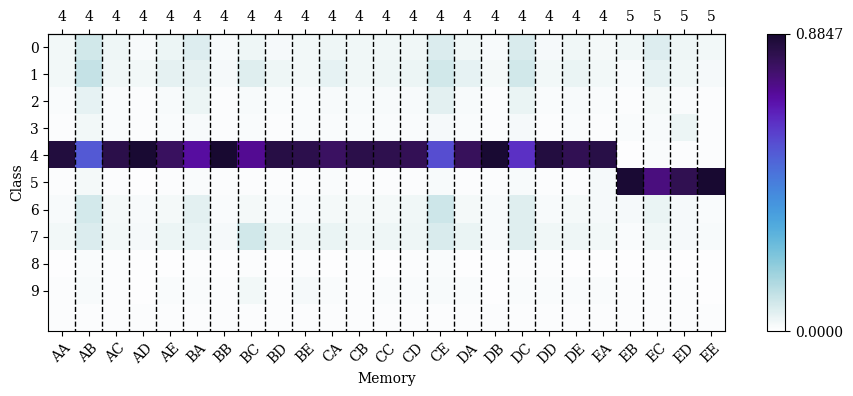

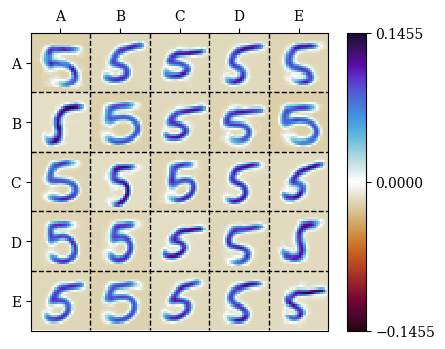

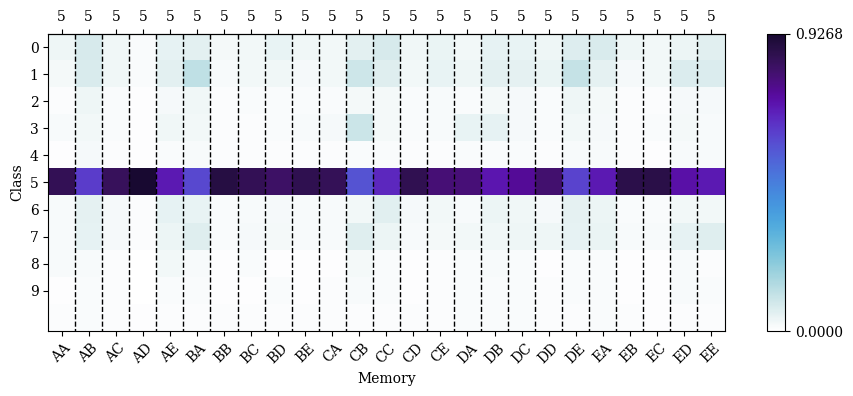

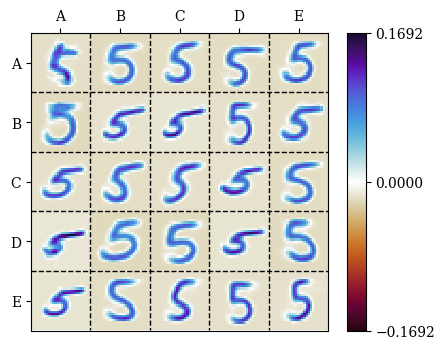

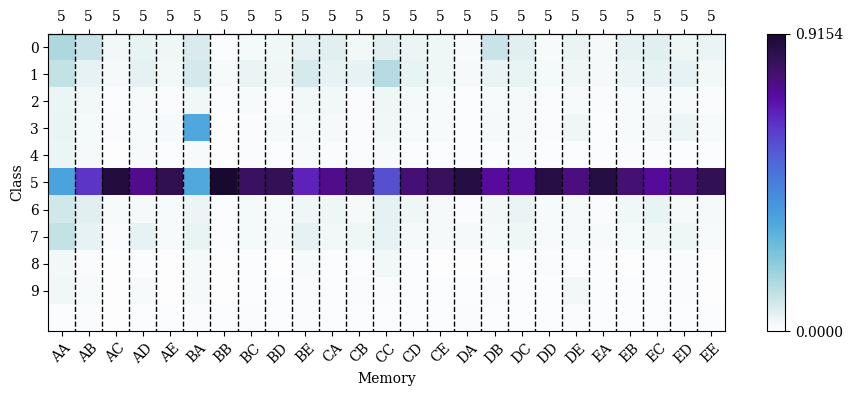

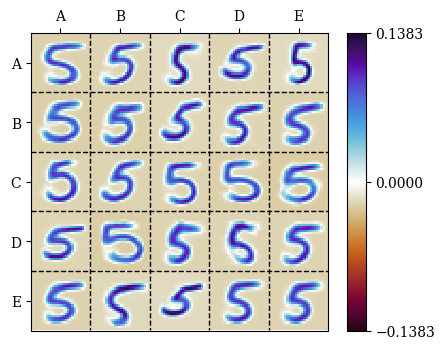

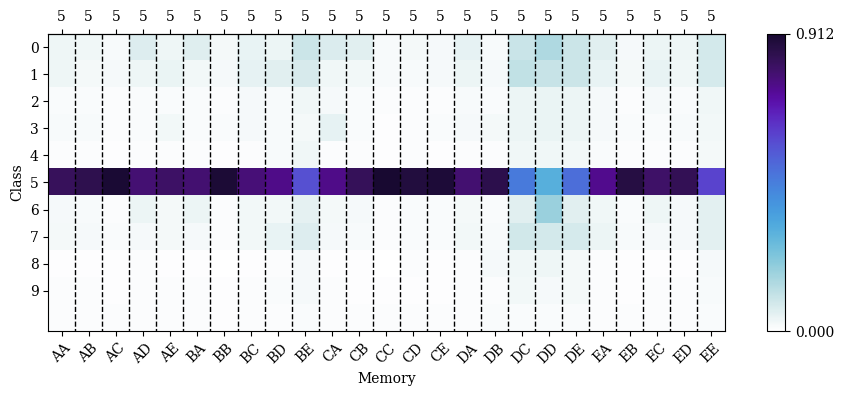

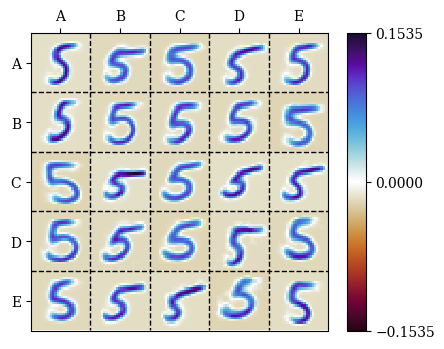

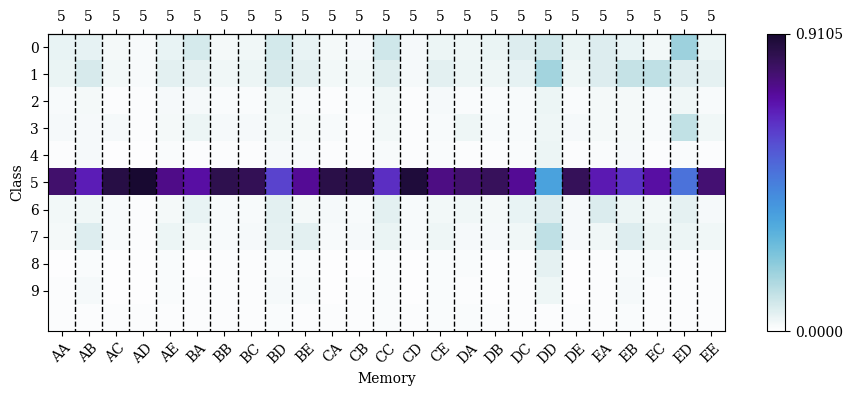

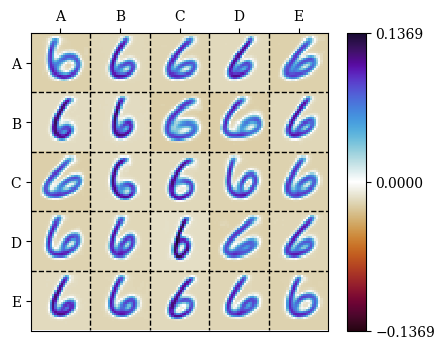

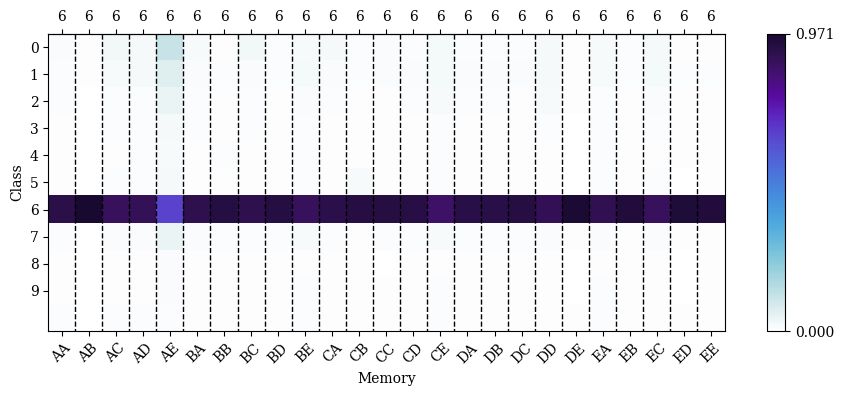

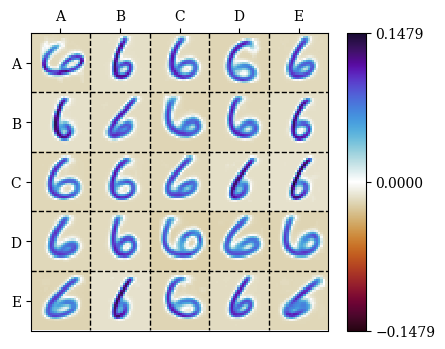

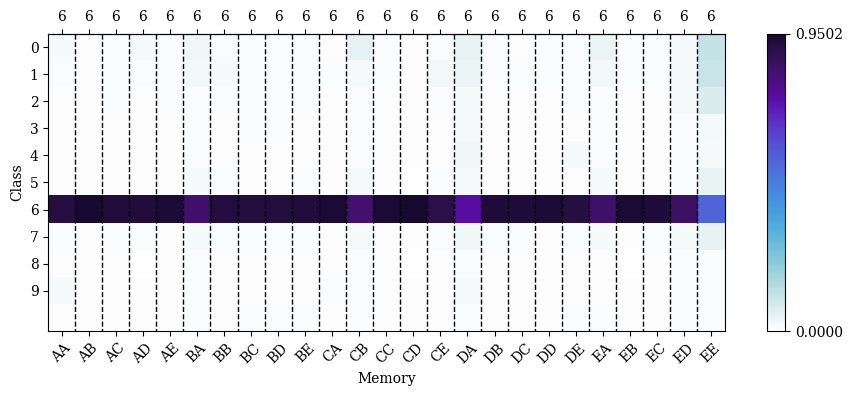

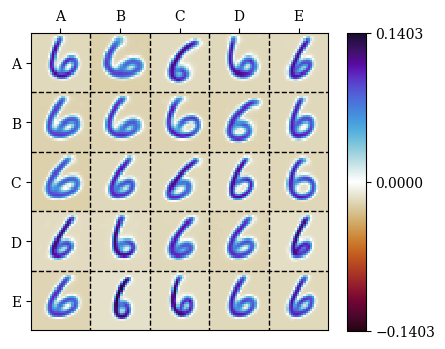

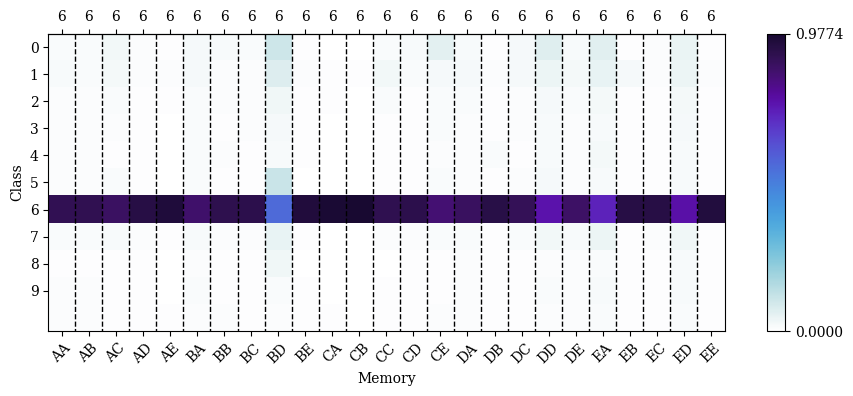

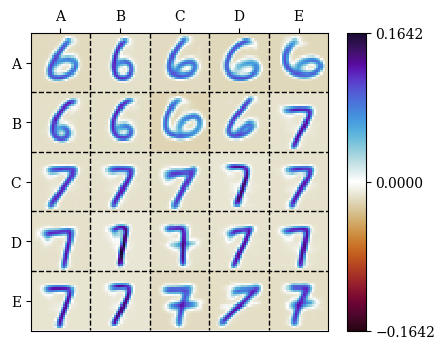

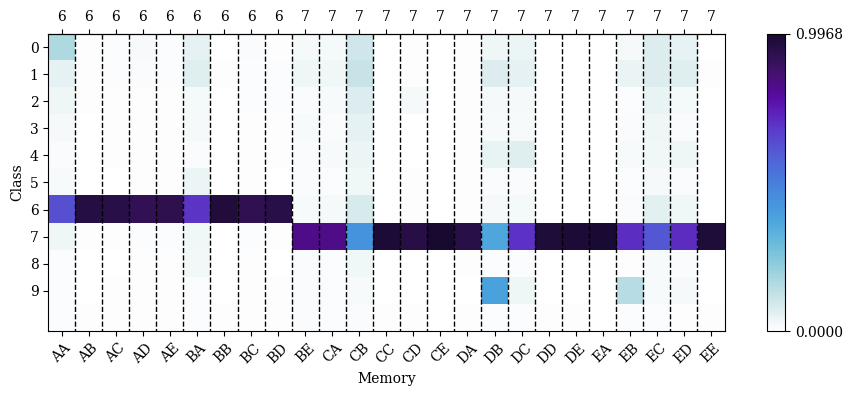

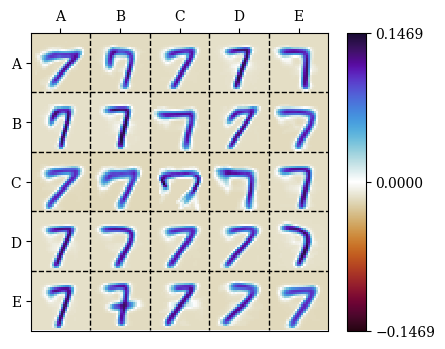

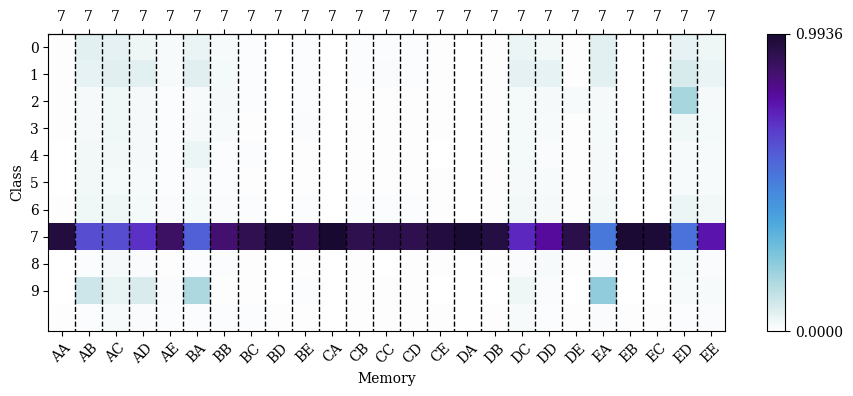

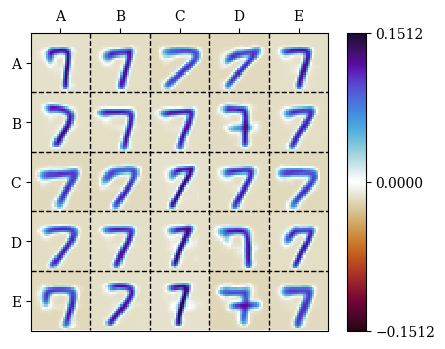

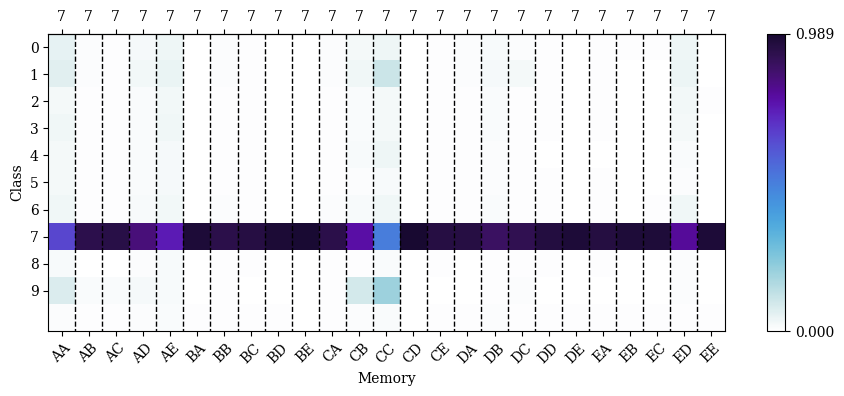

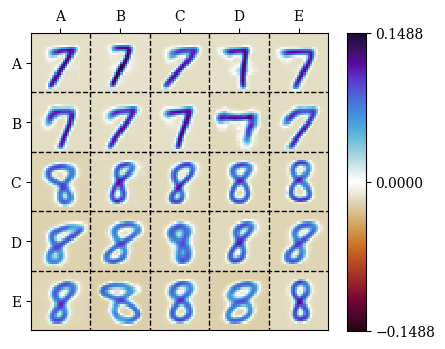

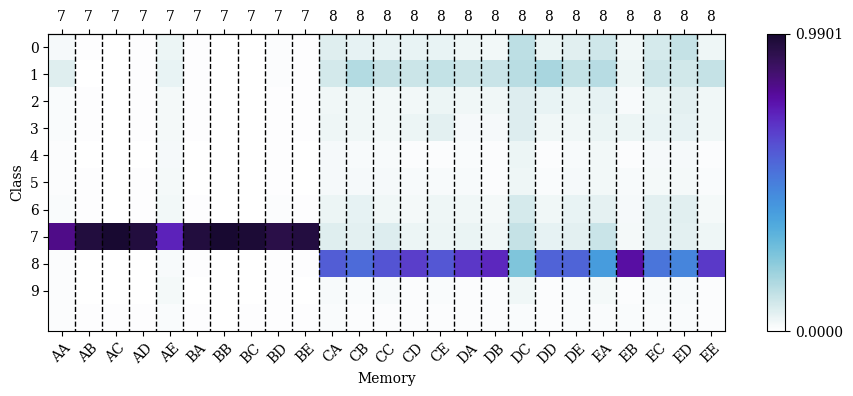

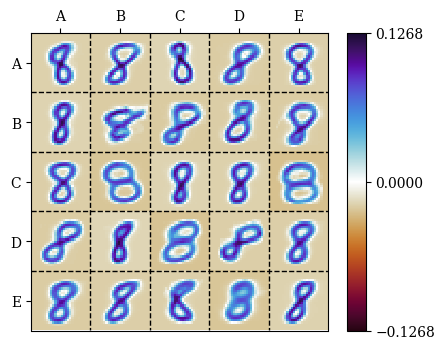

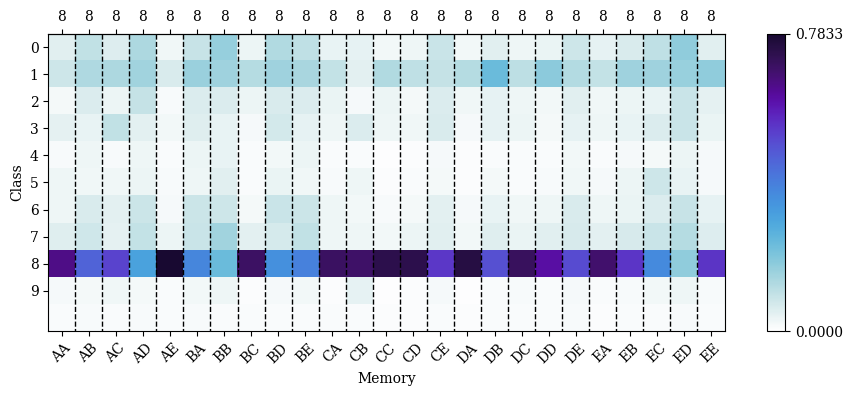

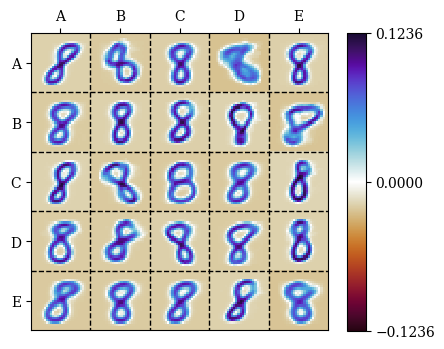

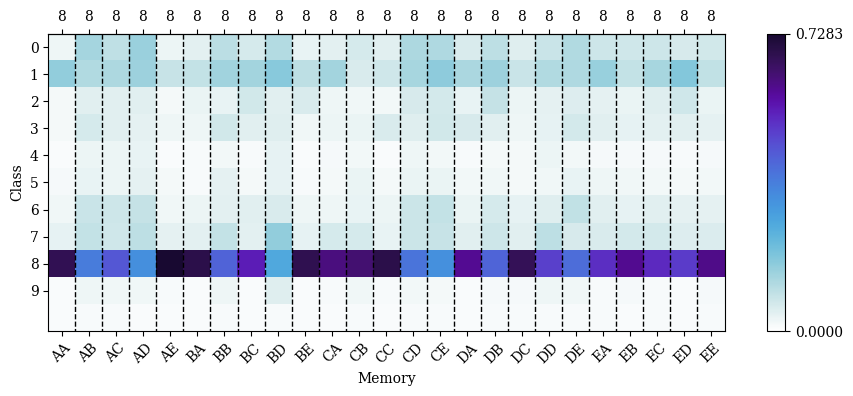

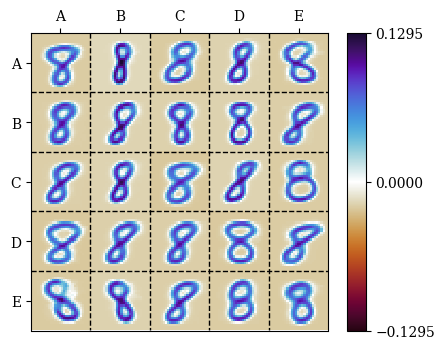

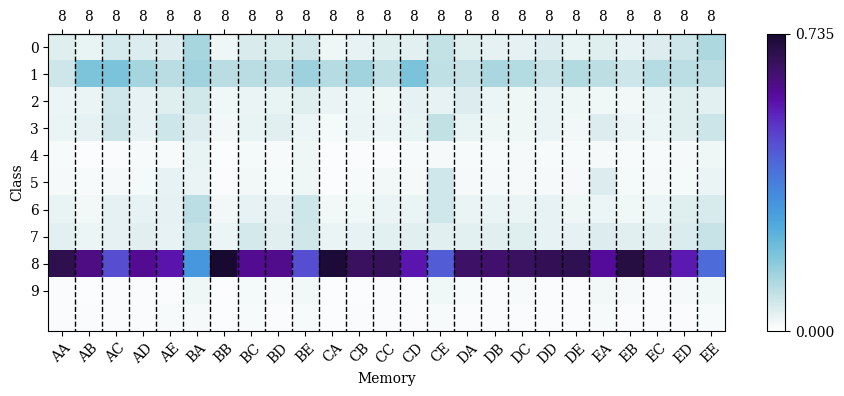

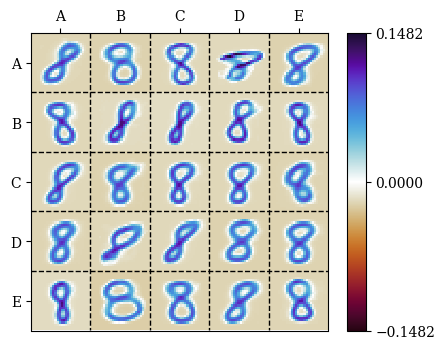

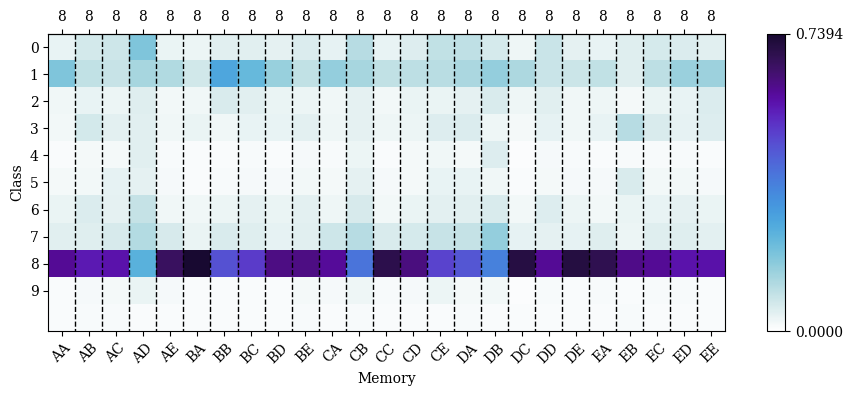

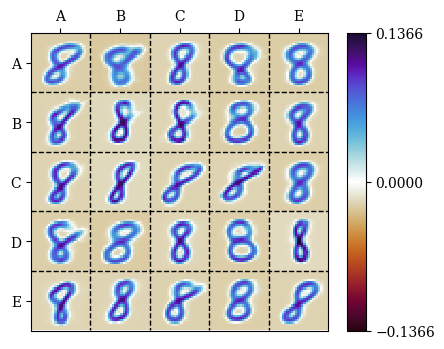

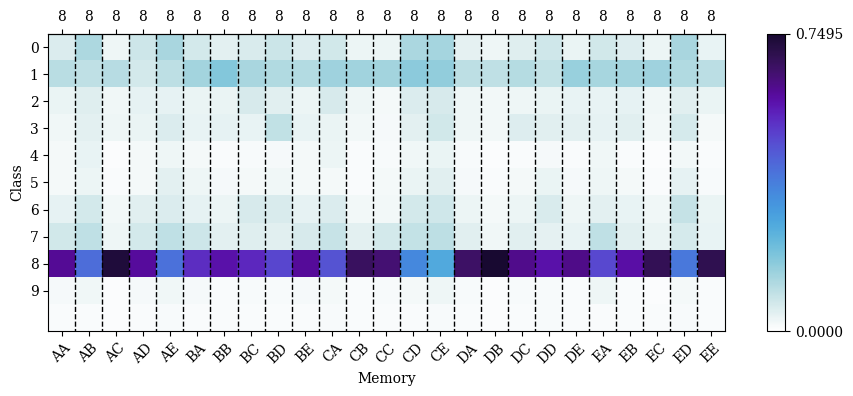

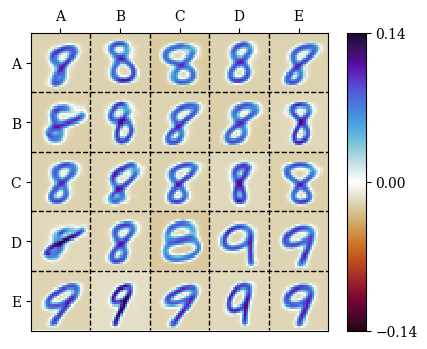

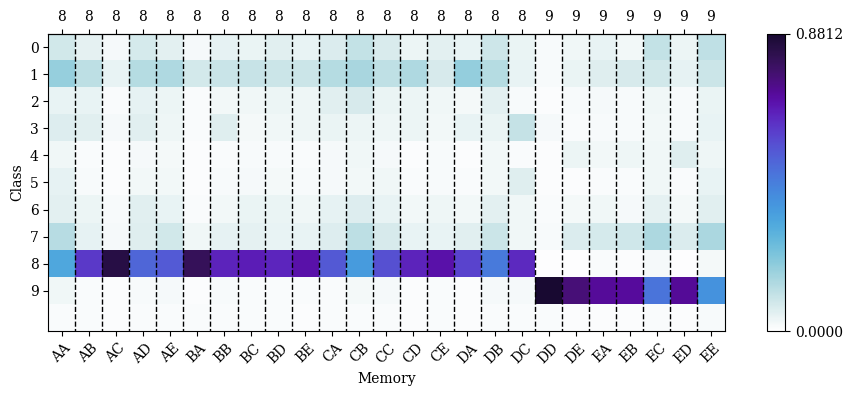

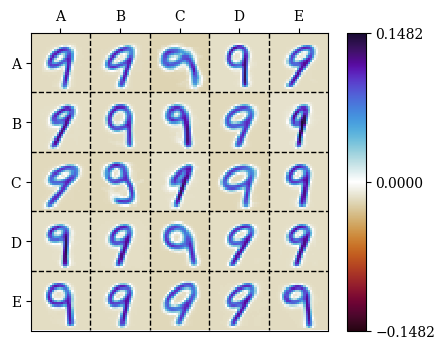

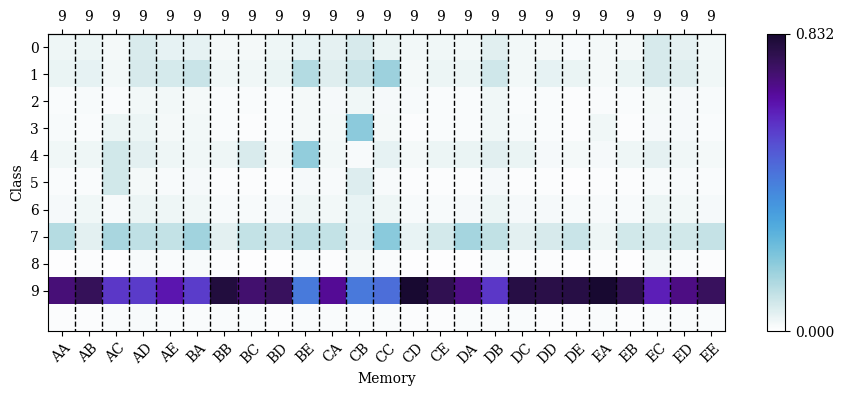

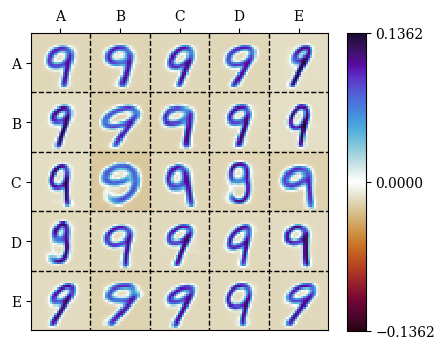

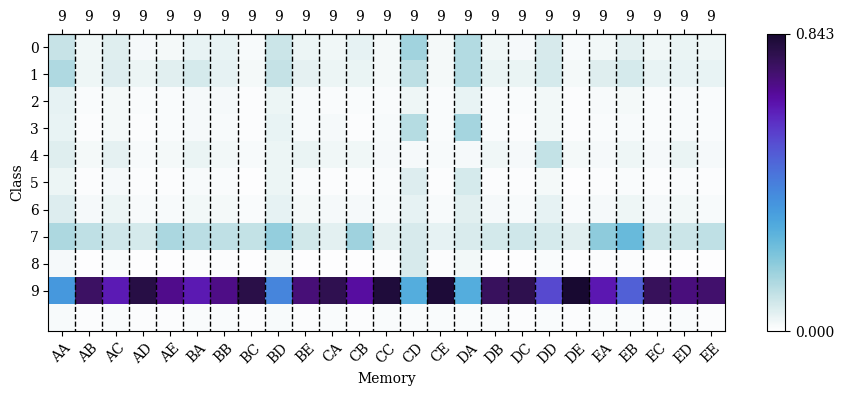

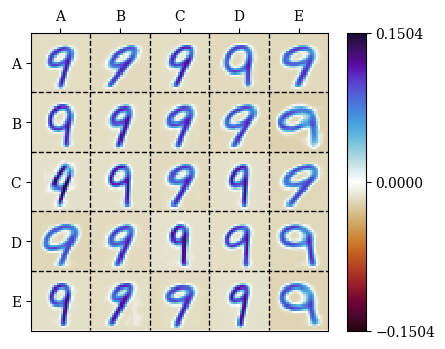

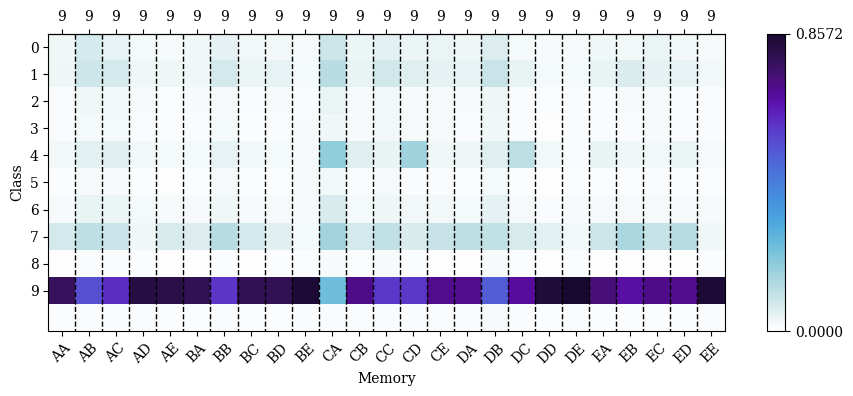

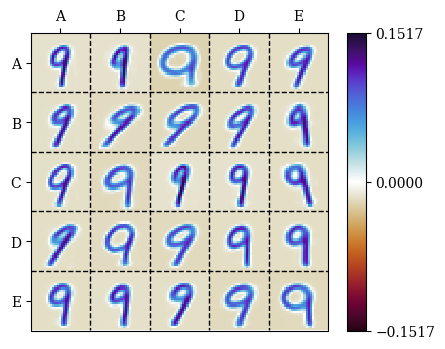

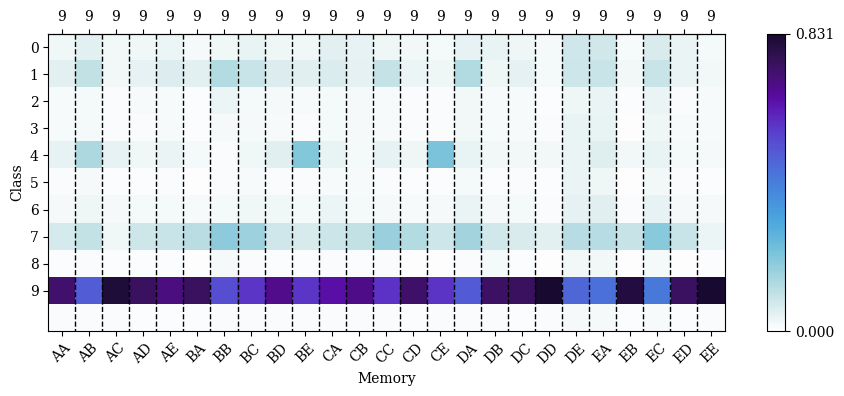

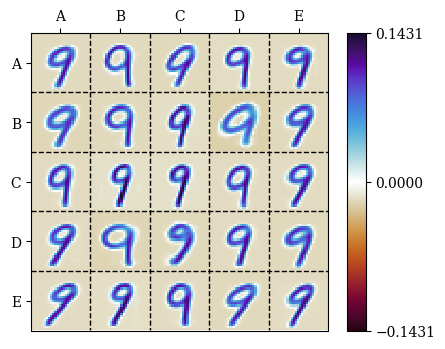

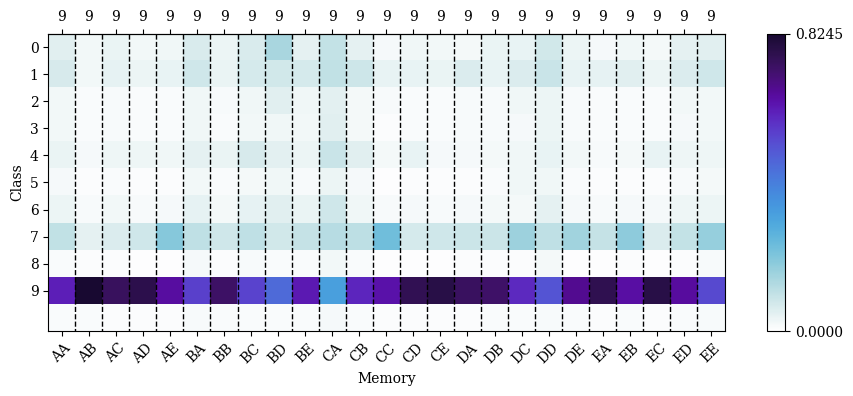

1/1 [==============================] - 0s 18ms/step


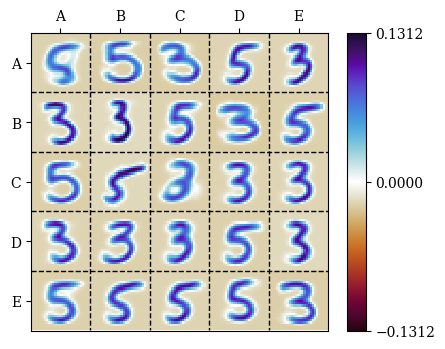

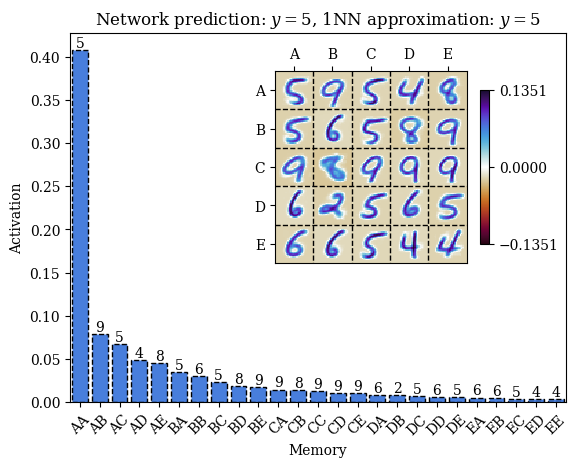

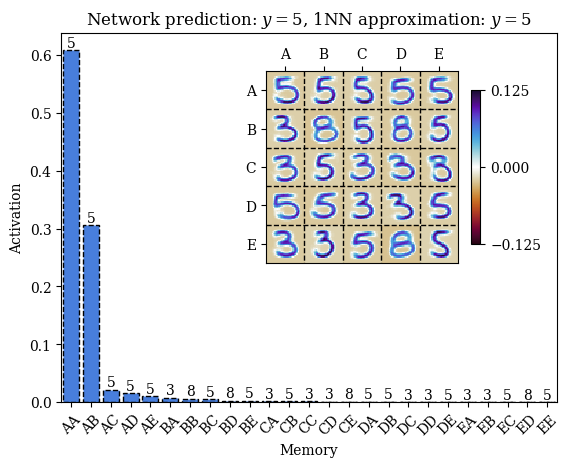

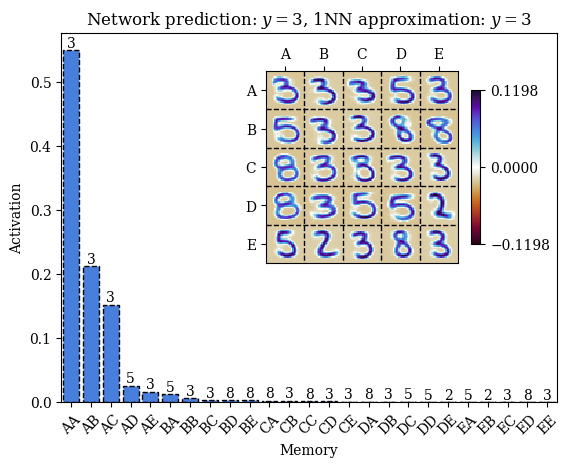

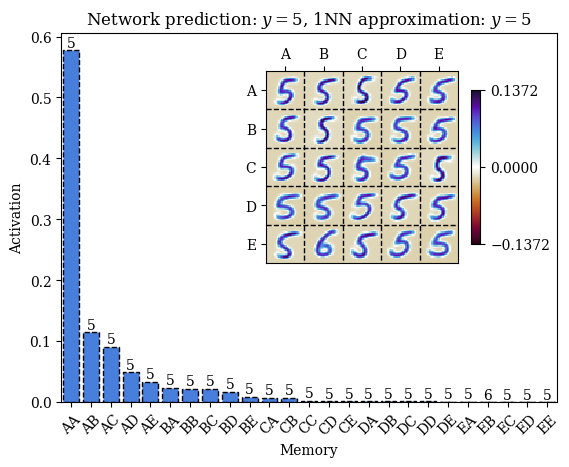

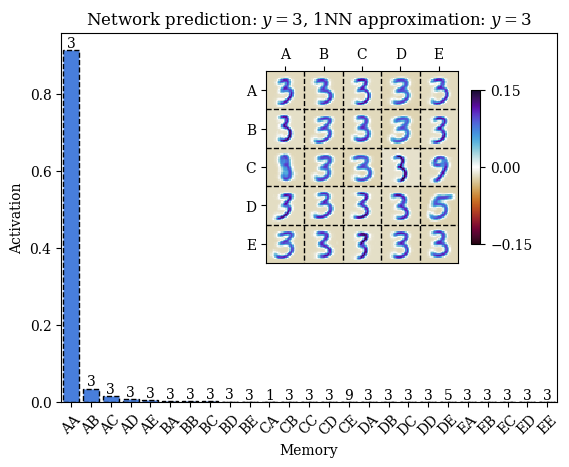

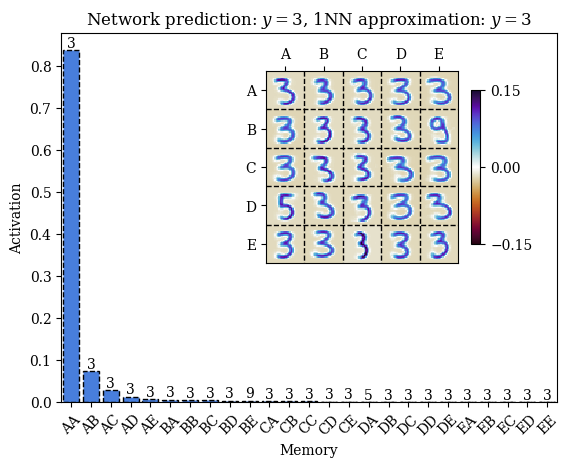

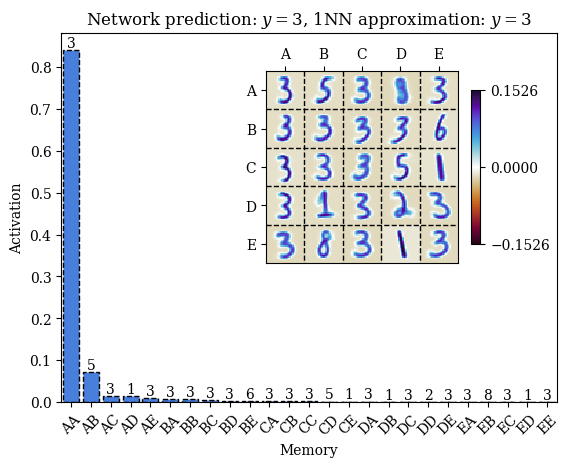

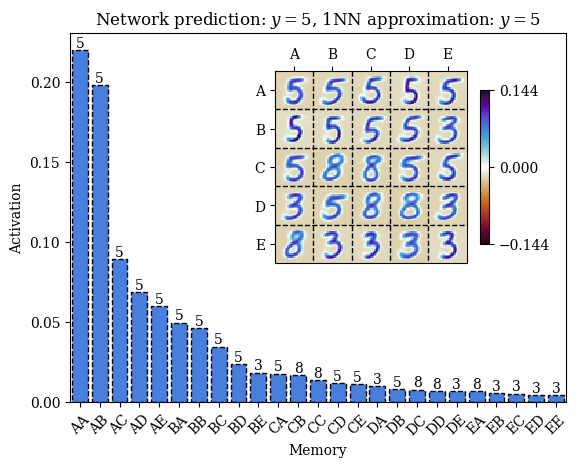

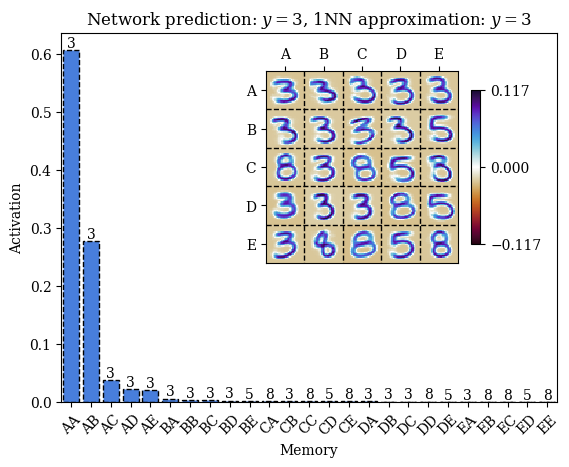

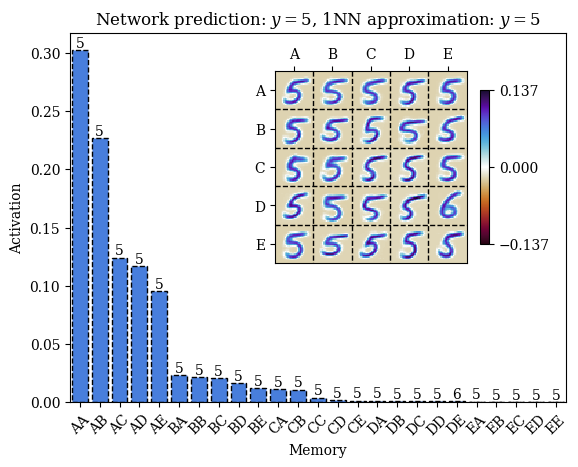

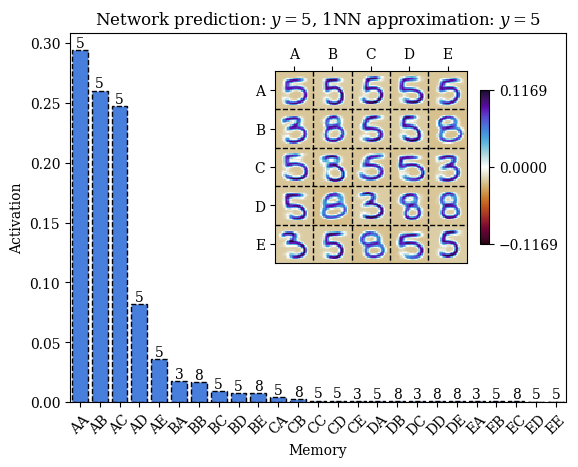

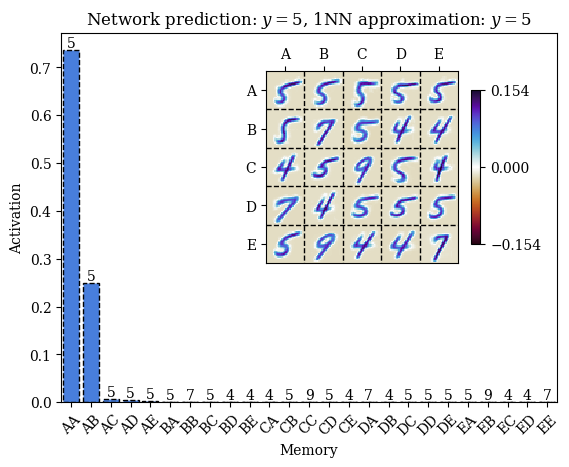

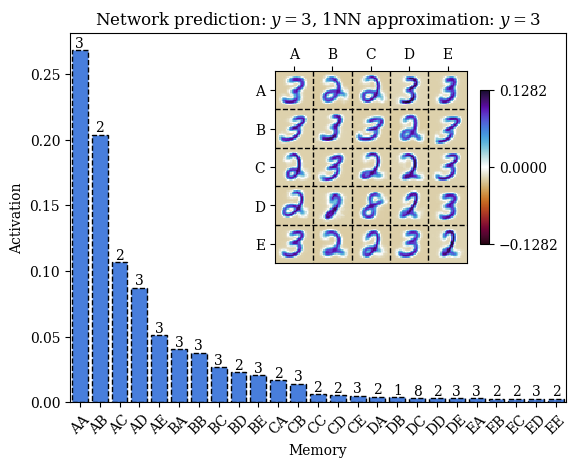

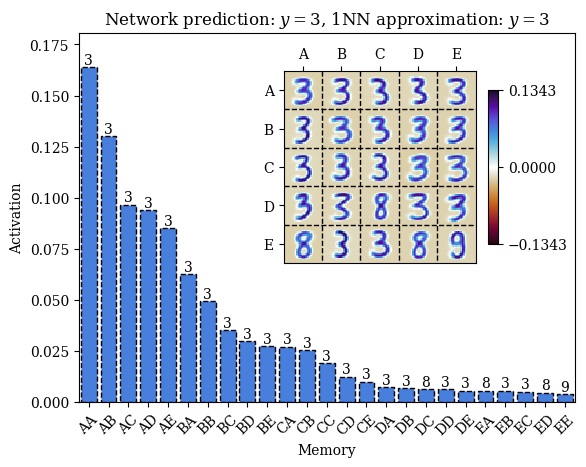

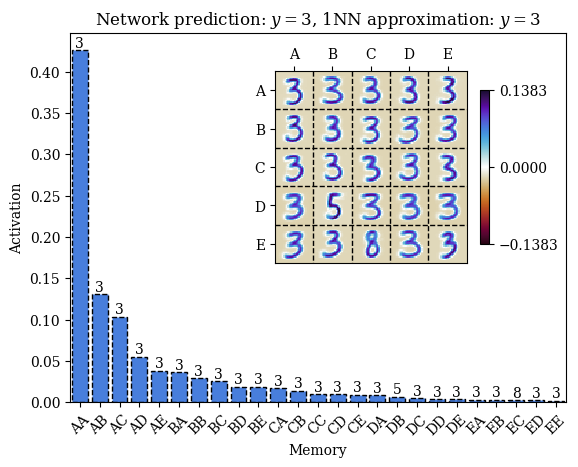

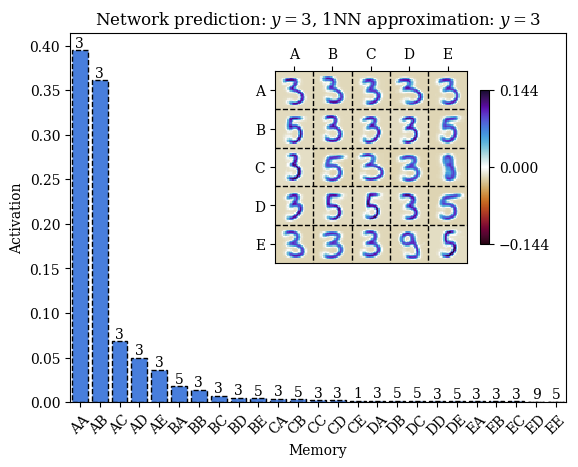

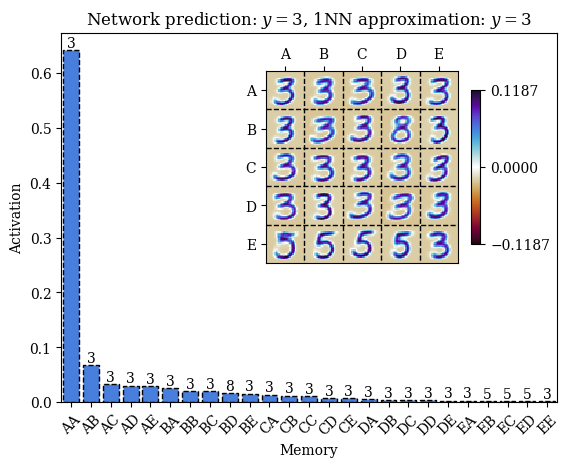

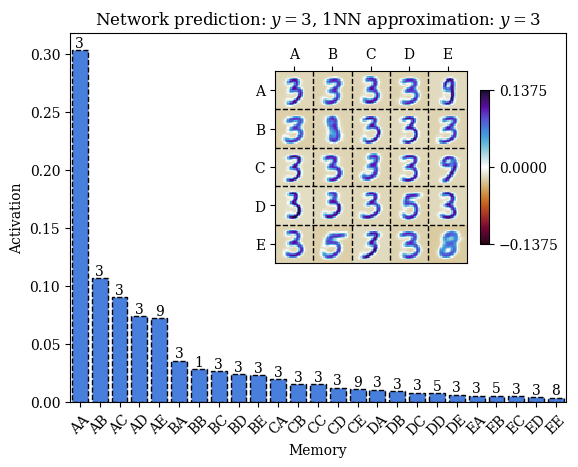

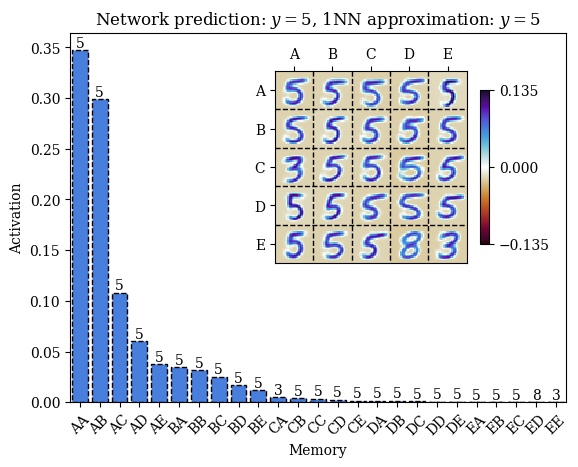

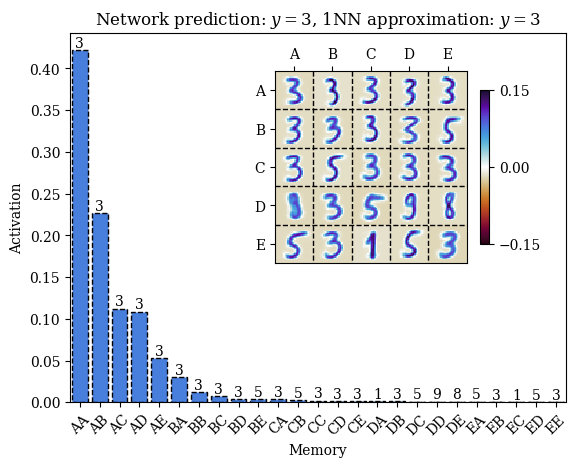

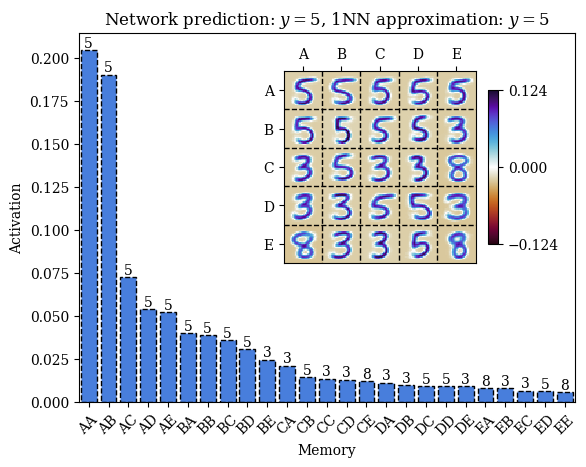

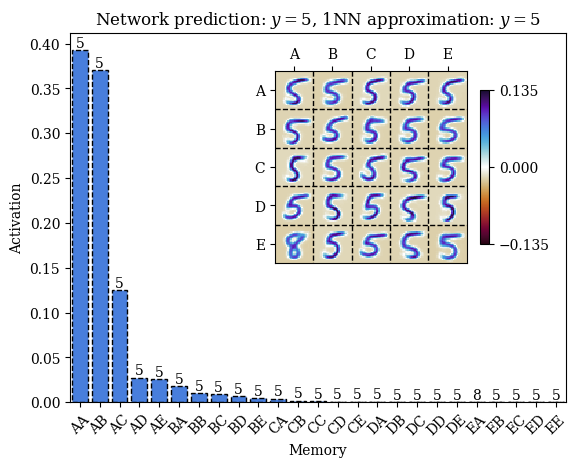

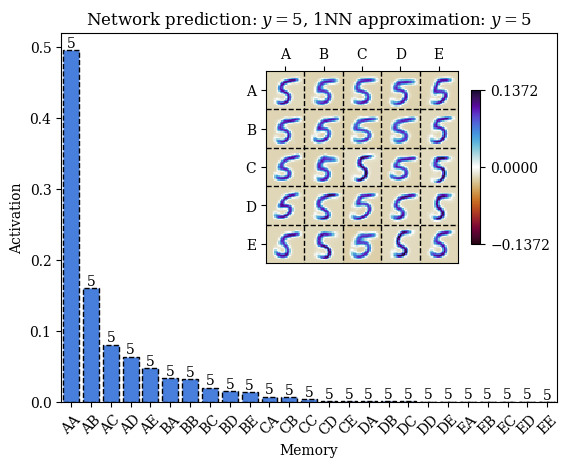

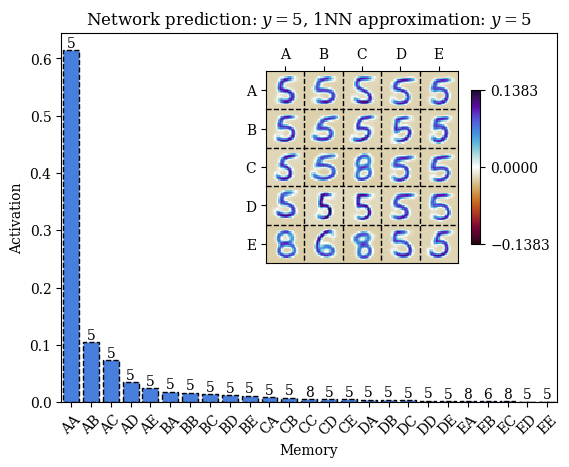

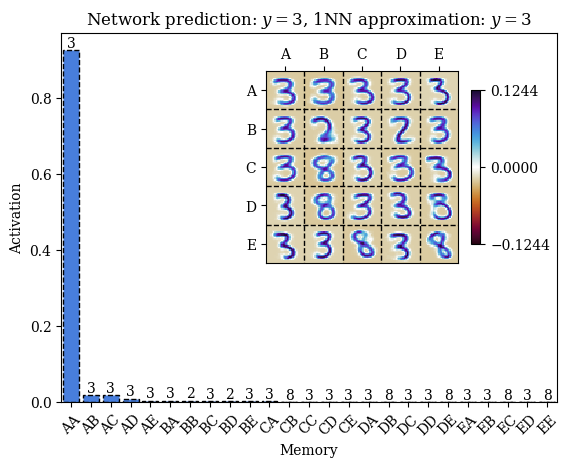

KeyboardInterrupt: 

In [5]:
#### MAIN.
def main():
    
    # Make sure all plots are closed
    plt.close("all")
    
    custom_objects = collect_custom_objects()
    
    seed = 76986 # 983476 # 1234
    # seed = 2412946043537042528
    # seed = 5077821058556905876
    np_rng = np.random.default_rng(seed)
    np_seed, tf_seed = np_rng.integers(0, 2**63, size = 2)
    np_rng = np.random.default_rng(np_seed)
    tf.random.set_seed(tf_seed)
    #tf.random.set_seed(seed)
    
    dataset = mnist
    softening = 0.1
    # dataset = fashion_mnist
    
    # Import data and reshape to vectors
    x_train, y_train, x_test, y_test = data_proc.prepare_flat_data(dataset, normalize_data = True, softening = softening)
    #x_train, y_train, x_test, y_test = data_proc.prepare_patch_data(dataset, normalize_data = True, softening = softening)
    
    #x_train = x_train / 5
    #x_test = x_test / 5
    
    #P_s = 10000
    #x_train = x_train[: P_s]
    #y_train = y_train[: P_s]
    
    # Loss type
    loss = "supervised"
    # loss = "unsupervised"
    
    number_features = x_train.shape[1]
    input_shape = (number_features,)
    #number_splits = -1
    # number_splits = 0
    number_splits = 14
    number_classes = y_train.shape[1] # 4
    number_constraint_iterations = 10
    batch_size = 1000
    
    # number_memorization_epochs = 100
    # number_annealing_epochs = 50
    
    number_memorization_epochs = 200
    number_annealing_epochs = 100
    # number_memorization_epochs = 250
    # number_annealing_epochs = 125
    #number_memorization_epochs = 300
    #number_annealing_epochs = 150
    
    number_splitting_epochs = 100
    # number_epochs = 800
    dataset_size = x_train.shape[0]
    
    # Hyperparameter values
    beta_init = 8. #2.
    beta_final = 40. #10.
    slope = 4
    ### ANCHOR. I put beta_init below instead of beta_final without verifying what it does.
    beta_range = np.concatenate([np.array([beta_init]), np.full((number_splits + 1,), beta_final)])
    patience = 1 #None
    
    # learning_rate = 0.1
    # momentum = 0.5 #0.9
    learning_rate = 0.1
    momentum = 0.99
    
    # max_fraction_eigvals = 0.2
    max_fraction_eigvals = 1.
    max_eigval = -0.001
    
    w_cur = None
    g_cur = None
    normalize_online = False
    save_model = True
    
    y_hard = np.argmax(y_train, axis = 1)
    counts_y = np.bincount(y_hard)
    
    #counts_y = np.array([110, 132, 121, 101])
    
    counts_y = np.concatenate([counts_y, np.array([0])])
    
    prior_y = (1 - softening) * counts_y / np.sum(counts_y) + softening * 1/(number_classes + 1)
    
    #max_number_memories = 100
    max_number_memories = 1000
    # max_number_memories = 2000
    
    #init_number_memories = 4
    #init_number_memories = 100
    init_number_memories = 1000
    # init_number_memories = 2000
    
    name = "DAN"
    record = None
    # record = "movies"
    
    if record == "movies":
        try:
            fname = "./Data/Weights/%s_w_with_beta=%s_and_for_movies.npy" % (name, str(beta_final))
            os.remove(fname)
        except OSError:
            pass
        try:
            fname = "./Data/Weights/%s_g_with_beta=%s_and_for_movies.npy" % (name, str(beta_final))
            os.remove(fname)
        except OSError:
            pass
    
    #model = models.init_normal_DAN(loss, beta_init, softening, number_features, init_number_memories, max_number_memories,
    #                               number_classes, number_constraint_iterations, learning_rate, momentum,
    #                               prior_y, normalize_online = normalize_online)
    
    model = models.init_DAN(loss, beta_init, softening, number_features, init_number_memories, max_number_memories,
                            number_classes, number_constraint_iterations, learning_rate, momentum,
                            prior_y, normalize_online = normalize_online)
    
    x_train = tf.convert_to_tensor(x_train, dtype = "float32")
    y_train = tf.convert_to_tensor(y_train, dtype = "float32")
    
    number_memories = init_number_memories
    start_time = time.perf_counter()
    for split in range(number_splits + 1):
        
        beta_init = beta_range[split]
        
        beta_final = beta_range[split + 1]
        
        model = models.train_DAN(x_train, y_train, model, number_memorization_epochs,
                                 number_annealing_epochs, batch_size, beta_final, slope, patience,
                                 training_phase = "memorization", record = record, verbose = True)
        
        number_memories = model.get_DAN_layer(1).output_size
        max_number_memories = model.get_DAN_layer(1).max_output_size
        
        if number_memories == max_number_memories:
            print("Maximum number of memories reached, cannot split any further.")
            if save_model:
                models.save_DAN(model, beta_final, number_memories, split)
            break
        
        elif split == number_splits:
            print("Maximum number of splits reached, splitting will stop.")
            if save_model:
                models.save_DAN(model, beta_final, number_memories, split)
            break
        
        else:
            model = models.train_DAN(x_train, y_train, model, number_splitting_epochs,
                                     0, batch_size, beta_final, slope, patience,
                                     training_phase = "splitting", record = None, verbose = True)
            
            max_number_eigvals = int(np.rint(max_fraction_eigvals * number_memories))
            mask = models.calc_split_mask(x_train, y_train, model, max_number_eigvals,
                                          max_eigval, batch_size, adjust = True)
            
            if not k.any(mask):
                print("Found no favorable eigendirection to split, splitting will stop.")
                if save_model:
                    models.save_DAN(model, beta_final, number_memories, split)
                break
            
            init.split_memories(model, mask, 0.25)
        
        w_cur = model.get_DAN_layer(1).get_weights()[0]
        g_cur = model.get_DAN_layer(2).get_weights()[0]
        
        w_plot = w_cur[:, : np.minimum(25, number_memories).astype("int")].T
        g_plot = g_cur[: np.minimum(25, number_memories).astype("int")].T
        
        res_plot.plot_images(w_plot)
        
        y_hard = np.argmax(model.predict(w_plot), axis = 1)
        res_plot.plot_labels(y_hard, g_plot)
    
    models.compile_memorization_phase(model)
    end_time = time.perf_counter()
    print(end_time - start_time)
    beta = beta_final
    number_memories = max_number_memories
    number_splits = np.ceil(np.log2(max_number_memories / init_number_memories)).astype("int")
    
    #number_units = 200
    #batch_size = 1000
    #number_epochs = 200
    #regularization = 5e-6
    #
    #model = models.init_vanilla_net(softening, number_features, number_units, number_classes,
    #                                learning_rate, momentum, regularization, normalize_online = False)
    #    
    #model = models.train_vanilla_net(x_train, y_train, model, number_epochs, batch_size, verbose = True)
    #
    #model = models.save_vanilla_net(model, number_units)
    
    model = models.load_DAN(beta, number_memories, number_splits, custom_objects)
    
    # Get hard test labels and predictions
    y_hard = np.argmax(y_test, axis = 1)
    y_pred = np.argmax(model(x_test), axis = 1)
    
    w = model.get_DAN_layer(1).get_weights()[0]
    g = model.get_DAN_layer(2).get_weights()[0]
    
    if loss == "supervised":
        model.evaluate(tf.convert_to_tensor(x_test, dtype = "float32"),
                       tf.convert_to_tensor(y_test, dtype = "float32"))
        
        res_test.first_neighbor_fidelity(x_test, y_hard, y_pred, w, g)
    
        res_plot.PCA_plot(model, x_train, x_test, y_hard, number_classes)
    
    w_plot = w[:, : 25].T
    g_plot = g[: 25].T
    
    res_plot.plot_images(w_plot)
    
    res_plot.plot_labels(np.argmax(model.predict(w_plot), axis = 1), g_plot)
    
    res_test.sort_prototypes(model, number_memories)
    
    softening = 0 #0.1 #None
    learning_rate = 0.01
    momentum = 0.9
    smoothing = momentum
    
    x_init = x_test[(y_hard == 5) | (y_hard == 3)][: 25]
    y_target = y_test[(y_hard == 5) | (y_hard == 3)][: 25]
    y_target = np.where(np.argmax(y_target, axis = 1, keepdims = True) == 5,
                        np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0]), np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0]))
    
    #y_target = (1 - softening) * y_target + softening / (y_target.shape[1] + 1)
    #x_init = x_init[2 : 3]
    #y_target = y_target[2 : 3]
    
    res_test.top_activated_memories(x_init, model)
    
    number_epochs = 10000*8
    x_final = res_test.generate_and_plot_data(x_init, y_target, model, softening, learning_rate, momentum, number_epochs)
    
    #y_target = np.argmax(y_target, axis = -1)
    
    res_test.first_neighbor_fidelity(x_final, np.argmax(y_target, axis = -1),
                                     np.argmax(model.predict(x_final), axis = -1), w, g)
    
    res_test.top_activated_memories(x_final, model)
    res_test.linear_decomposition(x_final, x_init, y_target, model, softening)
    
    x_init = x_test[: 25]#[15 : 16]
    y_target = tf.one_hot(np.argsort(model.predict(x_init), axis = 1)[:, -2], 10).numpy()
    
    #y_target = (1 - softening) * y_target + softening / (y_target.shape[1] + 1)
    
    res_test.top_activated_memories(x_init, model)
    
    number_epochs = 10000*8
    x_final = res_test.generate_and_plot_data(x_init, y_target, model, softening, learning_rate, momentum, number_epochs)
    
    #y_target = np.argmax(y_target, axis = -1)
    
    res_test.first_neighbor_fidelity(x_final, np.argmax(y_target, axis = -1),
                                     np.argmax(model.predict(x_final), axis = -1), w, g)
    
    res_test.top_activated_memories(x_final, model)
    res_test.linear_decomposition(x_final, x_init, y_target, model, softening)
    
    x_init = x_test[(y_hard == 4) | (y_hard == 9)][: 25]
    y_target = y_test[(y_hard == 4) | (y_hard == 9)][: 25]
    y_target = np.where(np.argmax(y_target, axis = 1, keepdims = True) == 4,
                        np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]), np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]))
    
    #y_target = (1 - softening) * y_target + softening / (y_target.shape[1] + 1)
    
    res_test.top_activated_memories(x_init, model)
    
    number_epochs = 10000*8
    x_final = res_test.generate_and_plot_data(x_init, y_target, model, softening, learning_rate, momentum, number_epochs)
    
    #y_target = np.argmax(y_target, axis = -1)
    
    res_test.first_neighbor_fidelity(x_final, np.argmax(y_target, axis = -1),
                                     np.argmax(model.predict(x_final), axis = -1), w, g)
    
    res_test.linear_decomposition(x_final, x_init, y_target, model, softening)
    res_test.top_activated_memories(x_final, model)
    
    del model
    
    #model = models.load_vanilla_net(number_units)
    #
    #model.evaluate(tf.convert_to_tensor(x_test, dtype = "float32"),
    #               tf.convert_to_tensor(y_test, dtype = "float32"))
    #
    #x_init = x_test[: 25][15 : 16]
    #
    ## y_target = np.ones((25, 10)) * np.array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]])
    ## y_target = np.roll(y_test[: 25], shift = 1, axis = 1)
    #y_target = tf.one_hot(np.argsort(model.predict(x_init), axis = 1)[:, -2], 10).numpy()
    #
    #learning_rate = 0.2
    #epsilon = 2. # 0.5
    #number_epochs = 5000
    #print(np.argmax(model.predict(x_init)))
    #x_final = res_test.generate_and_plot_data(x_init, y_target, model, softening, epsilon, learning_rate, momentum, number_epochs)
    #print(np.argmax(model.predict(x_final)))
    
if __name__ == "__main__":
    main()

[<keras.src.engine.input_layer.InputLayer object at 0x7ffe368b0460>, <DAN_code.layers.Normalize object at 0x7ffe36073d00>, <DAN_code.layers.DenseCor object at 0x7ffe35fc7280>, <DAN_code.layers.LogDenseExp object at 0x7ffe35efea30>]


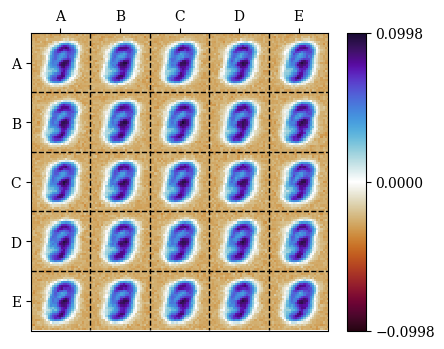

Epoch 1/600
10/10 [==============================] - 1s 15ms/step - loss: -8.0227 - accuracy: 0.1170
Epoch 2/600
10/10 [==============================] - 0s 13ms/step - loss: -8.0236 - accuracy: 0.1170
Epoch 3/600
10/10 [==============================] - 0s 13ms/step - loss: -8.0250 - accuracy: 0.1170
Epoch 4/600
10/10 [==============================] - 0s 13ms/step - loss: -8.0269 - accuracy: 0.1170
Epoch 5/600
10/10 [==============================] - 0s 12ms/step - loss: -8.0295 - accuracy: 0.1170
Epoch 6/600
10/10 [==============================] - 0s 12ms/step - loss: -8.0325 - accuracy: 0.1170
Epoch 7/600
10/10 [==============================] - 0s 12ms/step - loss: -8.0360 - accuracy: 0.1170
Epoch 8/600
10/10 [==============================] - 0s 13ms/step - loss: -8.0400 - accuracy: 0.1170
Epoch 9/600
10/10 [==============================] - 0s 12ms/step - loss: -8.0445 - accuracy: 0.1170
Epoch 10/600
10/10 [==============================] - 0s 12ms/step - loss: -8.0494 - accura

KeyboardInterrupt: 

In [2]:
# Make sure all plots are closed
plt.close("all")

custom_objects = collect_custom_objects()

seed = 2 # 76986 # 983476 # 1234
tf.random.set_seed(seed)

dataset = mnist
softening = 0.1
# dataset = fashion_mnist

# Import data and reshape to vectors
x_train, y_train, x_test, y_test = data_proc.prepare_flat_data(dataset, normalize_data = True, softening = softening)

x_train = x_train[: 1000]
y_train = y_train[: 1000]

# Loss type
loss = "supervised"
# loss = "unsupervised"

number_features = x_train.shape[1]
input_shape = (number_features,)
#number_splits = 0
number_splits = 14
number_classes = y_train.shape[1]
number_constraint_iterations = 10
batch_size = 100
#number_memorization_epochs = 300
#number_annealing_epochs = 150
number_memorization_epochs = 600
number_annealing_epochs = 300
number_splitting_epochs = 300
dataset_size = x_train.shape[0]

# Hyperparameter values
# beta_init = 2.
beta_init = 8.
beta_final = 40.
beta_range = np.concatenate([np.array([beta_init]), np.full((number_splits + 1,), beta_final)])
slope = 2
patience = 2#4

learning_rate = 0.1
momentum = 0.99

max_fraction_eigvals = 1.
max_eigval = -0.001

w_cur = None
g_cur = None
normalize_online = False
save_model = True

y_hard = np.argmax(y_train, axis = 1)
counts_y = np.bincount(y_hard)
counts_y = np.concatenate([counts_y, np.array([0])])
prior_y = (1 - softening) * counts_y / np.sum(counts_y) + softening * 1/(number_classes + 1)
max_number_memories = 400

#init_number_memories = 100
init_number_memories = 400

name = "DAN"
#record = "weights_with_splitting"
record = "weights_without_splitting"

if record is not None:
    if record[: 7] == "weights":
        try:
            fname = "./Data/Weights/%s_w_with_beta=%s_and_%s.npy" % (name, str(beta_final), record[8 :])
            os.remove(fname)
        except OSError:
            pass
        try:
            fname = "./Data/Weights/%s_g_with_beta=%s_and_%s.npy" % (name, str(beta_final), record[8 :])
            os.remove(fname)
        except OSError:
            pass
    
model = models.init_DAN(loss, beta_init, softening, number_features, init_number_memories, max_number_memories,
                        number_classes, number_constraint_iterations, learning_rate, momentum,
                        prior_y, normalize_online = normalize_online)

w = model.get_DAN_layer(1).get_weights()

w_init = np.mean(x_train, axis = 0, keepdims = True).T
w_init = w_init / np.sum(w_init**2, keepdims = True)**(1/2)
w_init = np.tile(w_init, reps = (1, init_number_memories))

w_init = init.random_vmf(w_init, eps**(-3/4))

w[0][:, : init_number_memories] = w_init

model.get_DAN_layer(1).set_weights(w)

w = get_DAN_layer(1).get_weights()[0]

w_plot = w[:, : 25].T

res_plot.plot_images(w_plot)

x_train = tf.convert_to_tensor(x_train, dtype = "float32")
y_train = tf.convert_to_tensor(y_train, dtype = "float32")

start_time = time.perf_counter()
for split in range(number_splits + 1):
    
    beta_init = beta_range[split]
    
    beta_final = beta_range[split + 1]
    
    model = models.train_DAN(x_train, y_train, model, number_memorization_epochs,
                             number_annealing_epochs, batch_size, beta_final, slope, patience,
                             training_phase = "memorization", record = record, verbose = True,
                             validation_split = 0)
    
    number_memories = model.get_DAN_layer(1).output_size
    max_number_memories = model.get_DAN_layer.max_output_size
    if number_memories == max_number_memories:
        print("Maximum number of memories reached, cannot split any further.")
        models.save_DAN(model, beta_final, number_memories, split)
        break
    
    elif split == number_splits:
        print("Maximum number of splits reached, splitting will stop.")
        models.save_DAN(model, beta_final, number_memories, split)
        break
    
    else:
        model = models.train_DAN(x_train, y_train, model, number_splitting_epochs,
                                 0, batch_size, beta_final, slope, patience,
                                 training_phase = "splitting", record = None, verbose = True,
                                 validation_split = 0)
        
        max_number_eigvals = int(np.rint(max_fraction_eigvals * number_memories))
        mask = models.calc_split_mask(x_train, y_train, model, max_number_eigvals,
                                      max_eigval, batch_size, adjust = True)
        
        if not k.any(mask):
            print("Found no favorable eigendirection to split, splitting will stop.")
            models.save_DAN(model, beta_final, number_memories, split)
            break
        
        init.split_memories(model, mask, 0.25)
    
    w_cur = model.get_DAN_layer(1).get_weights()[0]
    g_cur = model.get_DAN_layer(2).get_weights()[0]
    
    w_plot = w_cur[:, : 25].T
    g_plot = g_cur[: 25].T
    
    # print(np.sum(g_cur, axis = 0))
    # print(np.sum(g_cur, axis = 1))
    
    res_plot.plot_images(w_plot)
    
    y_hard = np.argmax(model.predict(w_plot), axis = 1)
    res_plot.plot_labels(y_hard, g_plot)

models.compile_memorization_phase(model)
end_time = time.perf_counter()
print(end_time - start_time)

Epoch 1/10
7776/7776 [==============================] - 29s 4ms/step - loss: -3.5292 - accuracy: 0.1450 - val_loss: -3.6272 - val_accuracy: 0.2936
Epoch 2/10
7776/7776 [==============================] - 47s 6ms/step - loss: -4.1223 - accuracy: 0.1603 - val_loss: -4.2069 - val_accuracy: 0.1487
Epoch 3/10
7776/7776 [==============================] - 46s 6ms/step - loss: -6.6776 - accuracy: 0.1633 - val_loss: -6.7266 - val_accuracy: 0.1565
Epoch 4/10
7776/7776 [==============================] - 46s 6ms/step - loss: -7.3757 - accuracy: 0.1592 - val_loss: -7.3957 - val_accuracy: 0.1567
Epoch 5/10
7776/7776 [==============================] - 46s 6ms/step - loss: -7.3925 - accuracy: 0.1588 - val_loss: -7.4121 - val_accuracy: 0.1569
Epoch 6/10
7776/7776 [==============================] - 47s 6ms/step - loss: -7.3925 - accuracy: 0.1590 - val_loss: -7.4122 - val_accuracy: 0.1556
Epoch 7/10
7776/7776 [==============================] - 46s 6ms/step - loss: -7.3925 - accuracy: 0.1586 - val_loss: -7

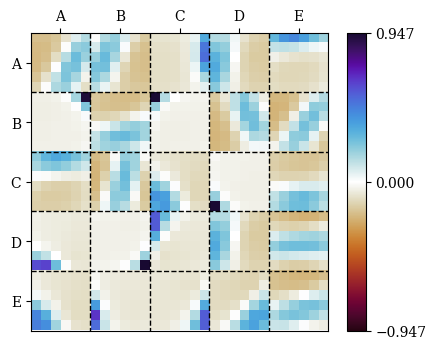

1/1 [==============================] - 0s 109ms/step


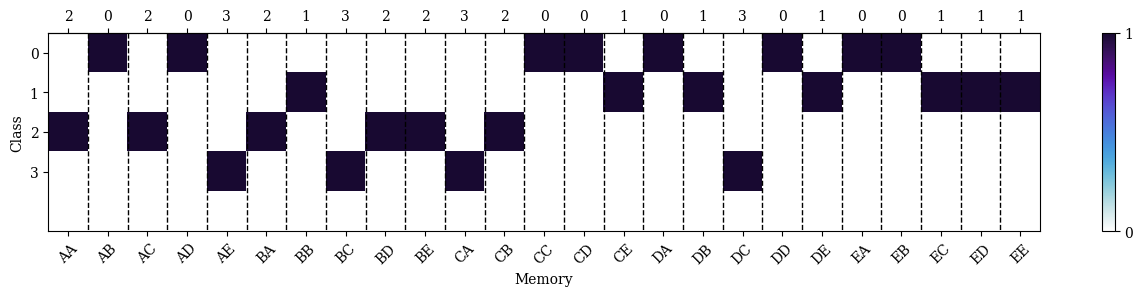

4/4 [==============================] - 0s 1ms/step


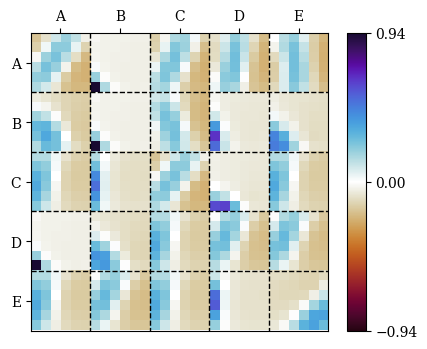

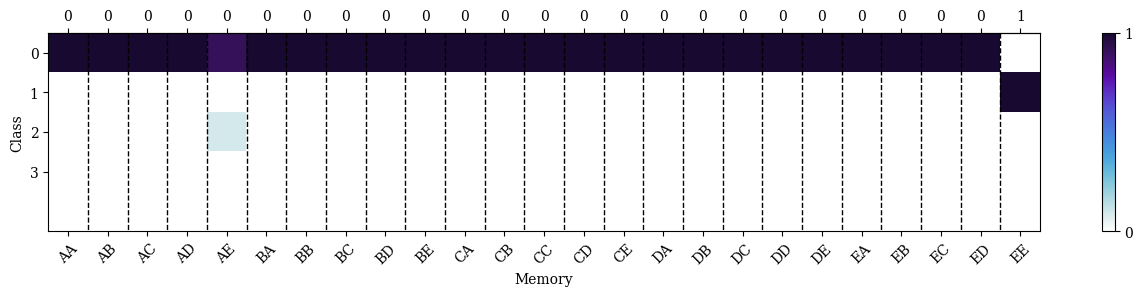

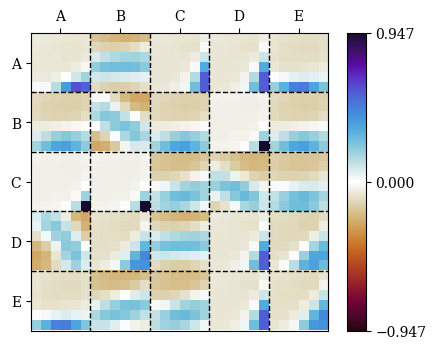

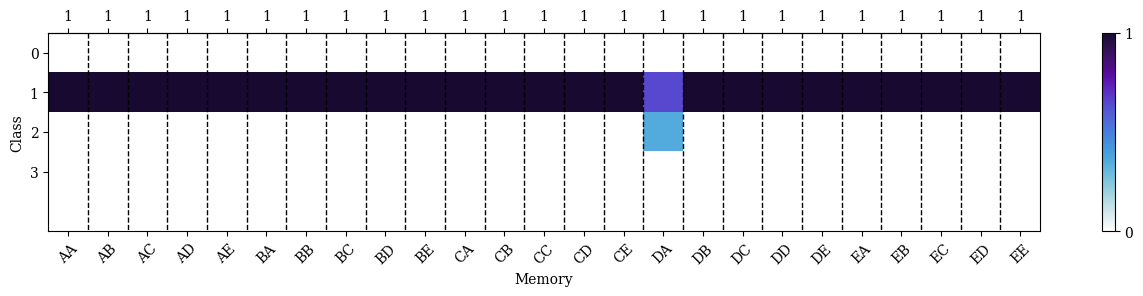

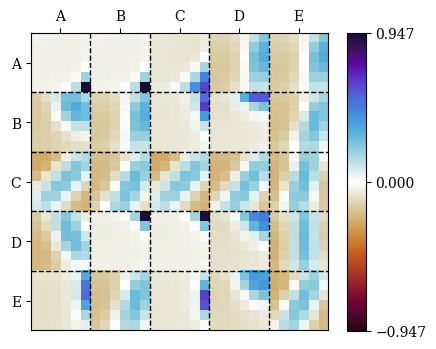

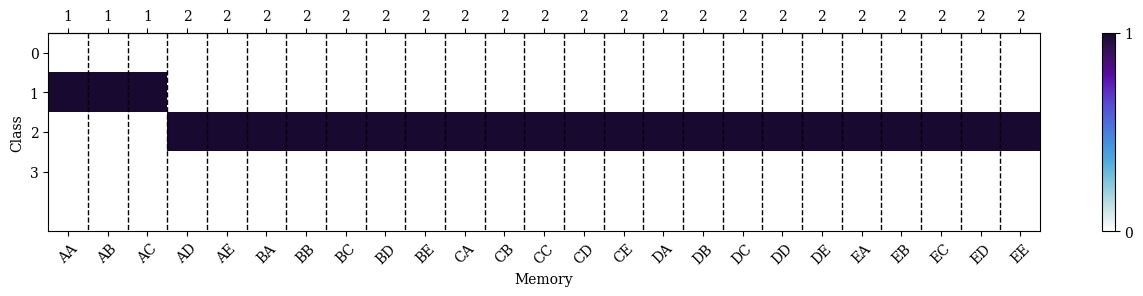

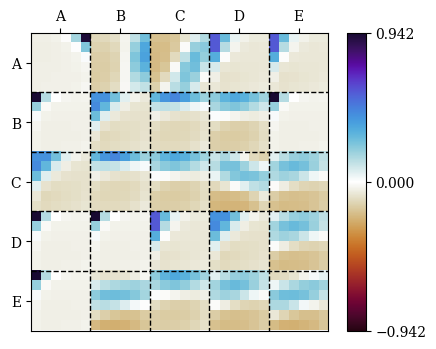

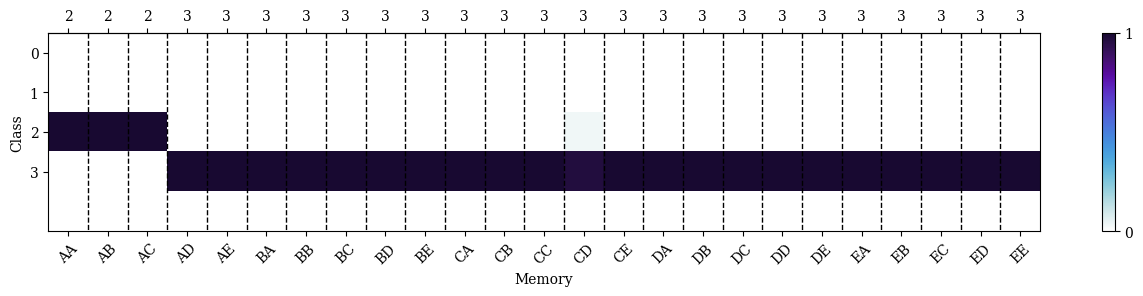

In [3]:
# Make sure all plots are closed
plt.close("all")

custom_objects = collect_custom_objects()

seed = 76986
np_rng = np.random.default_rng(seed)
np_seed, tf_seed = np_rng.integers(0, 2**63, size = 2)
np_rng = np.random.default_rng(np_seed)
tf.random.set_seed(tf_seed)

dataset = mnist
softening = 0.01
# dataset = fashion_mnist

# Import data and reshape to vectors
x_train, y_train, x_test, y_test = data_proc.prepare_patch_data(dataset, normalize_data = True, softening = softening)

# Loss type
loss = "unsupervised"

number_features = x_train.shape[1]
input_shape = (number_features,)
#number_splits = -1
number_splits = 0
number_classes = 4
number_constraint_iterations = 100
batch_size = 1000

number_memorization_epochs = 10
number_annealing_epochs = 5

number_splitting_epochs = 10
dataset_size = x_train.shape[0]

# Hyperparameter values
beta_init = 2.
beta_final = 10.
slope = 4
beta_range = np.concatenate([np.array([beta_init]), np.full((number_splits + 1,), beta_final)])
patience = 1 #None

learning_rate = 0.1
momentum = 0.99

max_fraction_eigvals = 1.
max_eigval = -0.001

w_cur = None
g_cur = None
normalize_online = False
save_model = True

counts_y = np.array([110, 132, 121, 101])

counts_y = np.concatenate([counts_y, np.array([0])])

prior_y = (1 - softening) * counts_y / np.sum(counts_y) + softening * 1/(number_classes + 1)

max_number_memories = 100

init_number_memories = 100

name = "DAN"
record = None
# record = "movies"

if record == "movies":
    try:
        fname = "./Data/Weights/%s_w_with_beta=%s_and_for_movies.npy" % (name, str(beta_final))
        os.remove(fname)
    except OSError:
        pass
    try:
        fname = "./Data/Weights/%s_g_with_beta=%s_and_for_movies.npy" % (name, str(beta_final))
        os.remove(fname)
    except OSError:
        pass

model = models.init_DAN(loss, beta_init, softening, number_features, init_number_memories, max_number_memories,
                        number_classes, number_constraint_iterations, learning_rate, momentum,
                        prior_y, normalize_online = normalize_online)

x_train = tf.convert_to_tensor(x_train, dtype = "float32")
y_train = tf.convert_to_tensor(y_train, dtype = "float32")

number_memories = init_number_memories
for split in range(number_splits + 1):
    
    beta_init = beta_range[split]
    
    beta_final = beta_range[split + 1]
    
    model = models.train_DAN(x_train, y_train, model, number_memorization_epochs,
                             number_annealing_epochs, batch_size, beta_final, slope, patience,
                             training_phase = "memorization", record = record, verbose = True)
    
    number_memories = model.get_DAN_layer(1).output_size
    max_number_memories = model.get_DAN_layer(1).max_output_size
    
    if number_memories == max_number_memories:
        print("Maximum number of memories reached, cannot split any further.")
        if save_model:
            models.save_DAN(model, beta_final, number_memories, split)
        break
    
    elif split == number_splits:
        print("Maximum number of splits reached, splitting will stop.")
        if save_model:
            models.save_DAN(model, beta_final, number_memories, split)
        break
    
    else:
        model = models.train_DAN(x_train, y_train, model, number_splitting_epochs,
                                 0, batch_size, beta_final, slope, patience,
                                 training_phase = "splitting", record = None, verbose = True)
        
        max_number_eigvals = int(np.rint(max_fraction_eigvals * number_memories))
        mask = models.calc_split_mask(x_train, y_train, model, max_number_eigvals,
                                      max_eigval, batch_size, adjust = True)
        
        if not k.any(mask):
            print("Found no favorable eigendirection to split, splitting will stop.")
            if save_model:
                models.save_DAN(model, beta_final, number_memories, split)
            break
        
        init.split_memories(model, mask, 0.25)
    
    w_cur = model.get_DAN_layer(1).get_weights()[0]
    g_cur = model.get_DAN_layer(2).get_weights()[0]
    
    print(np.sum(g_cur, axis = 1))
    
    w_plot = w_cur[:, : np.minimum(25, number_memories).astype("int")].T
    g_plot = g_cur[: np.minimum(25, number_memories).astype("int")].T
    
    res_plot.plot_images(w_plot)
    
    y_hard = np.argmax(model.predict(w_plot), axis = 1)
    res_plot.plot_labels(y_hard, g_plot)

models.compile_memorization_phase(model)
beta = beta_final
number_memories = max_number_memories
number_splits = np.ceil(np.log2(max_number_memories / init_number_memories)).astype("int")

model = models.load_DAN(beta, number_memories, number_splits, custom_objects)

w = model.get_DAN_layer(1).get_weights()[0]
g = model.get_DAN_layer(2).get_weights()[0]
counts_memory = model.get_DAN_layer(2).counts_memory.numpy()

w_plot = w[:, : 25].T
g_plot = g[: 25].T

res_plot.plot_images(w_plot)

res_plot.plot_labels(np.argmax(model.predict(w_plot), axis = 1), g_plot)

res_test.sort_prototypes(model, number_memories)

del model